In [1]:
%%html
<!-- run this to get markdown tables to align left -->
<style>table { display: inline-block }</style>

In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import sys
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import impute
from sklearn import preprocessing
from scipy.stats import norm
np.random.seed(37)

sys.path.append(os.path.realpath('../src/data/'))
from sb_utils import save_file

<a id='contents'></a>
# Contents

* [Project Overview](#overview) 
    * [1.0 Import Data](#import)
    * [1.1 CDI Data](#cdi)
    * [1.2 AQI Data](#aqi)
    * [1.3 Grouping CDI and AQI Dataframes](#group)
    * [1.4 Merging CDI and AQI Dataframes](#merge)
    * [1.5 Standardizing Data](#standard)
    * [1.6 Finding Data Distributions](#dist)
    * [1.7 Feature Determination](#features)
    * [1.8 Save Data](#save)
    * [1.9 Summary](#summary)

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='import'></a>
## 1.0 Import Data
Import the raw data from `data > raw` and write it out to the `data > interim directory`. We'll work from the interim folder.

In [3]:
# the supplied CSV data file is the raw_data directory
aqi_df = pd.read_csv('../data/interim/aqi_yearly_1980_to_2021.csv')
aqi_df.sample(5)

State   County  Year  Days with AQI  Good Days  Moderate Days  \
15185  Missouri     Clay  2002            364        162            162   
26564  Michigan  Clinton  2014            182        148             33   
16781   Georgia   Murray  2004            284        190             89   
2406    Arizona    Pinal  1985            365        100             43   
17637  Colorado  Larimer  2005            365        236            117   

       Unhealthy for Sensitive Groups Days  Unhealthy Days  \
15185                                   30              10   
26564                                    1               0   
16781                                    5               0   
2406                                   100             122   
17637                                   11               1   

       Very Unhealthy Days  Hazardous Days  ...  90th Percentile AQI  \
15185                    0               0  ...                  108   
26564                    0               0  ...                   64   
16781                    0               0  ...                   80   
2406                     0               0  ...                  200   
17637                    0               0  ...                   80   

       Median AQI  Days CO  Days NO2  Days Ozone  Days SO2  Days PM2.5  \
15185          53        0        21         153         4         186   
26564          41        0         0         182         0           0   
16781          44        0         0         205         0          79   
2406          119        0         0           0       365           0   
17637          48        0         0         352         0          13   

       Days PM10   Latitude   Longitude  
15185          0  39.331913  -94.580931  
26564          0  42.798339  -84.393795  
16781          0  34.785219  -84.626423  
2406           0  33.293465 -111.285594  
17637          0  40.577470 -105.078920  

[5 rows x 21 columns]

In [4]:
# the supplied CSV data file is the raw_data directory
cdi_df = pd.read_csv('../data/interim/US_Chronic_Disease_Indicators_CDI.csv')
cdi_df.sample(4)

YearStart  YearEnd LocationAbbr LocationDesc DataSource  \
1655       2010     2010           MO     Missouri       NVSS   
1686       2018     2018           MT      Montana       NVSS   
3760       2013     2013           TN    Tennessee      BRFSS   
2807       2013     2013           IN      Indiana      BRFSS   

                                      Topic  \
1655  Chronic Obstructive Pulmonary Disease   
1686  Chronic Obstructive Pulmonary Disease   
3760  Chronic Obstructive Pulmonary Disease   
2807  Chronic Obstructive Pulmonary Disease   

                                               Question      DataValueUnit  \
1655  Mortality with chronic obstructive pulmonary d...  cases per 100,000   
1686  Mortality with chronic obstructive pulmonary d...  cases per 100,000   
3760  Prevalence of chronic obstructive pulmonary di...                  %   
2807  Prevalence of chronic obstructive pulmonary di...                  %   

         DataValueType  DataValue  DataValueAlt StratificationCategory1  \
1655        Crude Rate      261.3         261.3                 Overall   
1686        Crude Rate      143.0         143.0                 Overall   
3760  Crude Prevalence        9.5           9.5                 Overall   
2807  Crude Prevalence       12.3          12.3                 Overall   

     Stratification1                                    GeoLocation  \
1655         Overall  POINT (-92.56630005299968 38.635790776000476)   
1686         Overall  POINT (-109.42442064499971 47.06652897200047)   
3760         Overall   POINT (-85.77449091399967 35.68094058000048)   
2807         Overall  POINT (-86.14996019399968 39.766910452000445)   

      LocationID TopicID QuestionID DataValueTypeID StratificationCategoryID1  \
1655          29    COPD    COPD1_2         CRDRATE                   OVERALL   
1686          30    COPD    COPD1_1         CRDRATE                   OVERALL   
3760          47    COPD    COPD2_0         CRDPREV                   OVERALL   
2807          18    COPD  COPD2_0_1         CRDPREV                   OVERALL   

     StratificationID1  
1655               OVR  
1686               OVR  
3760               OVR  
2807               OVR

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='cdi'></a>
## 1.1 CDI Data

Lets remove the rows with empty values

In [5]:
cdi_df = cdi_df[~ cdi_df.DataValueAlt.isnull()]
assert len(cdi_df[cdi_df.DataValueAlt.isnull()]) == 0

The information about each measure is below. Note that all measures are per state.

| Topic         | Question      | Derivation |
| :------------- | :------------- | :---------- |
|  __Chronic Obstructive Pulmonary Disease__ | Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years  |  cases per 100,000 |
|   | Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years  |  cases per 100,000 |
|   | Prevalence of chronic obstructive pulmonary disease among adults >= 18  |  % of population |
|   | Prevalence of chronic obstructive pulmonary disease among adults >= 45 years  |  % of population |
|   | Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease  |  % of population |
|   | Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease  |  % of population |
|  __Cancer__ | Cancer of the lung and bronchus, incidence  |  cases per 100,000 |
|   | Cancer of the lung and bronchus, mortality |  cases per 100,000 |
|  __Asthma__ | Current asthma prevalence among adults aged >= 18 years | % of population |


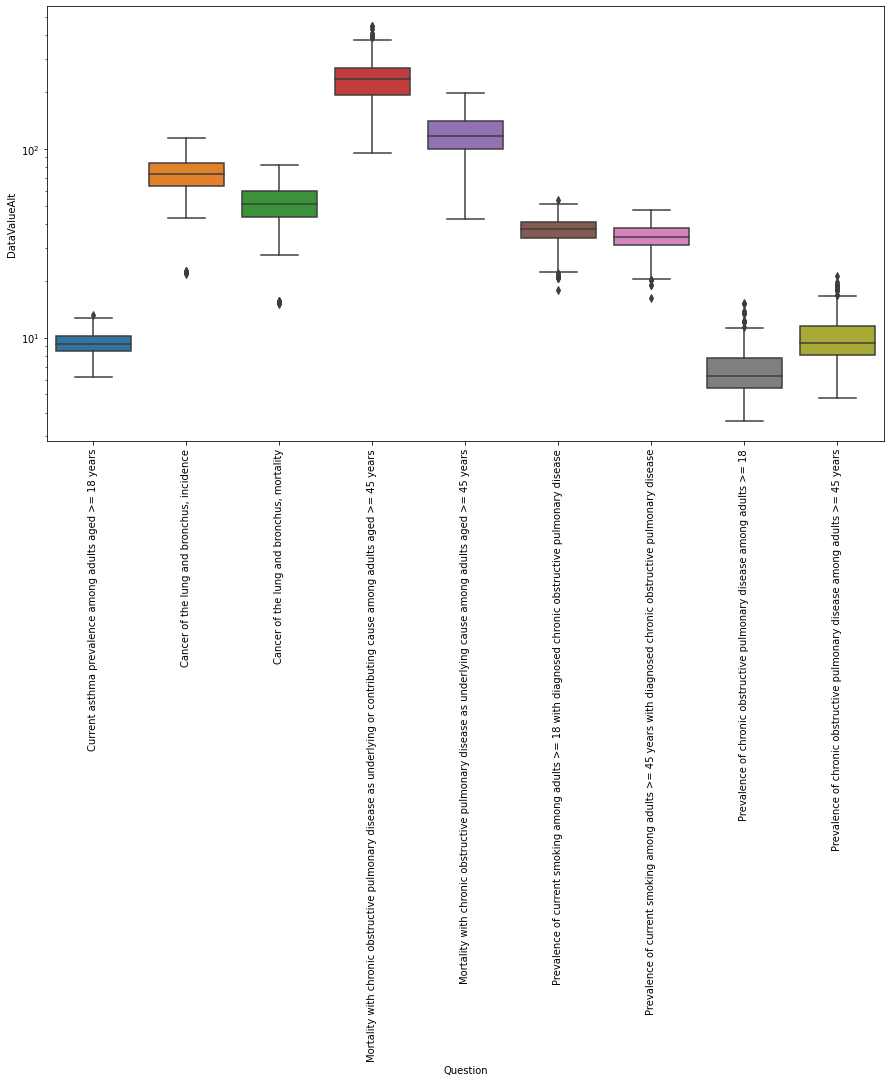

In [6]:
# the overall mean, median, IQR for each Question in CDI
cols = ['LocationDesc','Question', 'DataValueAlt']

plt.subplots(figsize=(15, 8))
sns.boxplot(x='Question', y="DataValueAlt", data=cdi_df[cols]).set_yscale('log')
plt.xticks(rotation='vertical');

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='aqi'></a>
## 1.2 AQI Data

Lets normalize the day measures by the number of day in which measures were taken ('Days AQI')

In [7]:
# Good Days, Moderate Days, Unhealthy for Sensitive Groups Days, Unhealthy Days, Very Unhealthy Days, Hazardous Days
aqi_df.iloc[:,4:10] = aqi_df.iloc[:,4:10].apply(lambda x: x/aqi_df.iloc[:,3], axis=0)
# Days CO, Days NO2, Days Ozone, Days SO2, Days PM2.5, Days PM10
aqi_df.iloc[:,13:19] = aqi_df.iloc[:,13:19].apply(lambda x: x/aqi_df.iloc[:,3], axis=0)
aqi_df.sample(10)


State           County  Year  Days with AQI  Good Days  \
5055       New York          Niagara  1989            364   0.401099   
32253      Colorado       Rio Blanco  2020            365   0.857534   
22015        Oregon           Harney  2009            360   0.725000   
5248     Washington          Clallam  1989            363   0.487603   
10085      Michigan          Oakland  1996            365   0.912329   
30441      Kentucky        McCracken  2018            364   0.692308   
14263     Minnesota       Washington  2001            365   0.860274   
25104    Washington           Asotin  2012            364   0.750000   
32144        Alaska  Aleutians East   2020             50   1.000000   
4512   Pennsylvania          Indiana  1988            141   0.531915   

       Moderate Days  Unhealthy for Sensitive Groups Days  Unhealthy Days  \
5055        0.368132                             0.225275        0.005495   
32253       0.134247                             0.008219        0.000000   
22015       0.275000                             0.000000        0.000000   
5248        0.267218                             0.198347        0.046832   
10085       0.071233                             0.016438        0.000000   
30441       0.307692                             0.000000        0.000000   
14263       0.115068                             0.019178        0.005479   
25104       0.222527                             0.013736        0.013736   
32144       0.000000                             0.000000        0.000000   
4512        0.333333                             0.134752        0.000000   

       Very Unhealthy Days  Hazardous Days  ...  90th Percentile AQI  \
5055                   0.0             0.0  ...                  116   
32253                  0.0             0.0  ...                   54   
22015                  0.0             0.0  ...                   68   
5248                   0.0             0.0  ...                  130   
10085                  0.0             0.0  ...                   48   
30441                  0.0             0.0  ...                   60   
14263                  0.0             0.0  ...                   54   
25104                  0.0             0.0  ...                   62   
32144                  0.0             0.0  ...                   26   
4512                   0.0             0.0  ...                  106   

       Median AQI   Days CO  Days NO2  Days Ozone  Days SO2  Days PM2.5  \
5055           60  0.008242  0.000000    0.390110  0.593407    0.000000   
32253          42  0.000000  0.002740    0.887671  0.000000    0.109589   
22015          30  0.000000  0.000000    0.000000  0.000000    1.000000   
5248           56  0.000000  0.000000    0.099174  0.884298    0.000000   
10085          19  0.526027  0.000000    0.473973  0.000000    0.000000   
30441          42  0.000000  0.002747    0.365385  0.000000    0.631868   
14263          31  0.000000  0.000000    0.523288  0.413699    0.000000   
25104          30  0.000000  0.000000    0.000000  0.000000    1.000000   
32144           9  0.000000  0.000000    0.000000  0.000000    1.000000   
4512           50  0.000000  0.000000    0.000000  1.000000    0.000000   

       Days PM10   Latitude   Longitude  
5055    0.008242  43.096373  -79.011447  
32253   0.000000  39.915300 -107.634500  
22015   0.000000  43.589250 -119.048720  
5248    0.016529  48.006295 -122.973953  
10085   0.000000  42.679172  -83.130141  
30441   0.000000  37.058220  -88.572510  
14263   0.063014  45.168004  -92.765136  
25104   0.000000  46.425416 -117.060445  
32144   0.000000  55.324675 -160.508331  
4512    0.000000  40.563330  -78.919972  

[10 rows x 21 columns]

AQI data correlations

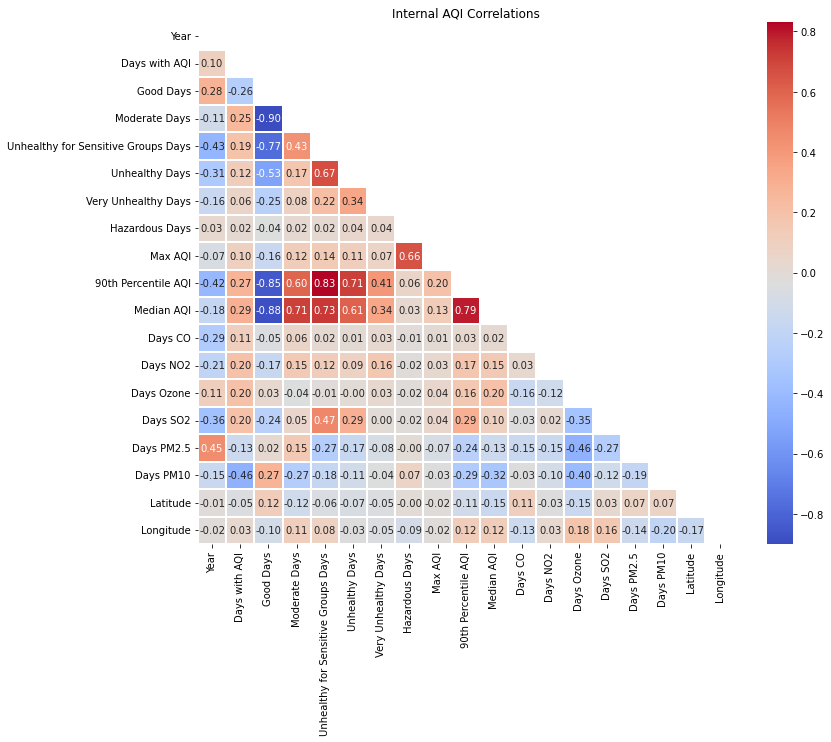

In [8]:
corrmat = aqi_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(12, 9))
_ = sns.heatmap(round(corrmat,2), annot=True, mask=mask, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05).set_title('Internal AQI Correlations')
f.subplots_adjust(top=0.93);

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='cdi'></a>
## 1.1 CDI Data

#### Check merge cols
We are merging on state and year so validate that these match across dataframes

##### State

In [9]:
states_aqi = set(aqi_df.State)
states_cdi = set(cdi_df.LocationDesc)
# compare sets by difference (expect none)
diff = states_aqi.difference(states_cdi)
diff

{'District Of Columbia'}

Washington DC differs between the two frames:
The AQI dataset has 'District Of Columbia' while the CDI dataset has 'District of Columbia' (the difference is 'Of' vs 'of'). Lets correct this:

In [10]:
aqi_df = aqi_df.replace('District Of Columbia','District of Columbia')

# check that there are no differences now
states_aqi = set(aqi_df.State)
states_cdi = set(cdi_df.LocationDesc)
# compare sets by difference (expect none)
diff = states_aqi.difference(states_cdi)
assert len(diff) == 0

##### Year

In [11]:
year_aqi = set(aqi_df.Year)
year_cdi = set(cdi_df.YearStart)
trim_years = year_aqi.difference(year_cdi)
print(trim_years)

{1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007}


The AQI dataset contains forty years of data, but the CDI dataset only contains data from 2008-2020. Since we need to join them, I'll truncate the AQI years that precede the CDI years.

In [12]:
aqi_df = aqi_df[~aqi_df['Year'].isin(list(trim_years))]
year_aqi = set(aqi_df.Year)
# make sure this worked
assert all(year >= 2008 for (year) in list(year_aqi))

We need to ensure that all (location, year) pairs align between dataframes 

In [13]:
aqi_state_year = aqi_df[['State','Year']].drop_duplicates()
cdi_state_year = cdi_df[['LocationDesc','YearStart']].drop_duplicates()

# ensure that unique (location, year) pairs are same size
assert len(aqi_state_year) == len(cdi_state_year)

sorted_aqi_state_year = aqi_state_year.sort_values(by=['State','Year']).values.tolist()
sorted_cdi_state_year = cdi_state_year.sort_values(by=['LocationDesc','YearStart']).values.tolist()    
    
# ensure that unique (location, year) pairs are same values
def sublists_equal(a, b):
    return all(l for l in b if l in a)

print(sublists_equal(sorted_aqi_state_year, sorted_cdi_state_year))

True


Rename CDI index keys to match AQI for easier merge

In [14]:
cdi_df = cdi_df.rename({
    'LocationDesc':'State',
    'YearStart':'Year'
    }, axis='columns')

In [15]:
# don't think this is necessary now
cdi_df.drop(['YearEnd'], axis=1, inplace=True)

Lets convert the Topic and Question categorical columns into one-hot encoded columns for correlation.

In [16]:
# creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
# perform one-hot encoding on 'Topic' column 
encoder_df = pd.DataFrame(encoder.fit_transform(cdi_df[['Topic']]).toarray())
# rename
encoder_df.columns = encoder.categories_[0]
# merge one-hot encoded columns back with original DataFrame
## MUST reset index before concat!
cdi_df.reset_index(drop=True, inplace=True)
encoder_df.reset_index(drop=True, inplace=True)
cdi_df = pd.concat([cdi_df, encoder_df], axis=1)
cdi_df.shape

(4272, 22)

In [17]:
# do the same for 'Question' column
encoder_df = pd.DataFrame(encoder.fit_transform(cdi_df[['Question']]).toarray())
encoder_df.columns = encoder.categories_[0]
## MUST reset index before concat!
cdi_df.reset_index(drop=True, inplace=True)
encoder_df.reset_index(drop=True, inplace=True)
cdi_df = pd.concat([cdi_df, encoder_df], axis=1)
cdi_df.shape

(4272, 31)

In [18]:
# for State
encoder_df = pd.DataFrame(encoder.fit_transform(cdi_df[['State']]).toarray())
encoder_df.columns = encoder.categories_[0]
## MUST reset index before concat!
cdi_df.reset_index(drop=True, inplace=True)
encoder_df.reset_index(drop=True, inplace=True)
cdi_df = pd.concat([cdi_df, encoder_df], axis=1)
cdi_df.shape

(4272, 82)

Right now, the geolocation data in cdi_df is encoded as 'POINT (-147.72205903599973 64.84507995700051)'. In order to plot this, we'll need to break it into longitude and latitude data.

In [19]:
# split the GeoLocation column into longitude and latitude cols
cdi_df[['Longitude','Latitude']] = cdi_df.GeoLocation.str.extract('^POINT+\s\((\-?\d+\.\d+)\s(\-?\d+\.\d+)\)$', expand=False)
cdi_df.loc[:,'Longitude'] = cdi_df.loc[:,'Longitude'].astype('float')
cdi_df.loc[:,'Latitude'] = cdi_df.loc[:,'Latitude'].astype('float')
# and drop GeoLocation column
cdi_df.drop(['GeoLocation','LocationID'], axis=1, inplace=True)

In [20]:
# drop columns that have been encoded
cdi_df.drop(['LocationAbbr','DataSource','DataValueUnit','DataValueType','Topic','Question','DataValue','StratificationCategory1','Stratification1','TopicID','QuestionID','DataValueTypeID','StratificationCategoryID1','StratificationID1'], axis=1, inplace=True)
# also drop (not needed)
# cdi_df.drop(['LocationID','Longitude','Latitude'], axis=1, inplace=True)
# #view final df
cdi_df.sample(10)

Year          State  DataValueAlt  Asthma  Cancer  \
3327  2012       Nebraska          31.7     0.0     0.0   
721   2010       Illinois          72.9     0.0     1.0   
970   2013       New York          71.4     0.0     1.0   
173   2011  Massachusetts          10.7     1.0     0.0   
4029  2018  West Virginia          43.1     0.0     0.0   
3542  2013       Oklahoma           7.8     0.0     0.0   
852   2009    Mississippi          84.6     0.0     1.0   
2901  2017       Kentucky          12.2     0.0     0.0   
4165  2020     New Mexico          27.7     0.0     0.0   
985   2013     New Jersey          42.8     0.0     1.0   

      Chronic Obstructive Pulmonary Disease  \
3327                                    1.0   
721                                     0.0   
970                                     0.0   
173                                     0.0   
4029                                    1.0   
3542                                    1.0   
852                                     0.0   
2901                                    1.0   
4165                                    1.0   
985                                     0.0   

      Cancer of the lung and bronchus, incidence  \
3327                                         0.0   
721                                          1.0   
970                                          1.0   
173                                          0.0   
4029                                         0.0   
3542                                         0.0   
852                                          1.0   
2901                                         0.0   
4165                                         0.0   
985                                          0.0   

      Cancer of the lung and bronchus, mortality  \
3327                                         0.0   
721                                          0.0   
970                                          0.0   
173                                          0.0   
4029                                         0.0   
3542                                         0.0   
852                                          0.0   
2901                                         0.0   
4165                                         0.0   
985                                          1.0   

      Current asthma prevalence among adults aged >= 18 years  \
3327                                                0.0         
721                                                 0.0         
970                                                 0.0         
173                                                 1.0         
4029                                                0.0         
3542                                                0.0         
852                                                 0.0         
2901                                                0.0         
4165                                                0.0         
985                                                 0.0         

      Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years  \
3327                                                0.0                                                        
721                                                 0.0                                                        
970                                                 0.0                                                        
173                                                 0.0                                                        
4029                                                0.0                                                        
3542                                                0.0                                                        
852                                                 0.0                                                        
2901                                                0.0                         

Lets rename columns to make plotting less crowded.

In [21]:
cdi_df = cdi_df.rename({
    'Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years': 'COPD mortality age >= 45', 
    'Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years':'COPD contributing mortality age >= 45',
    'Prevalence of chronic obstructive pulmonary disease among adults >= 18':'COPD prevalence age >= 18',
    'Prevalence of chronic obstructive pulmonary disease among adults >= 45 years':'COPD prevalence age >= 45',
    'Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease':'smoking and COPD prevalence age >= 18',
    'Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease':'smoking and COPD prevalence age >= 45',
    'Current asthma prevalence among adults aged >= 18 years':'Asthma prevalence age >= 18'
    }, axis='columns')
cdi_df.columns

Index(['Year', 'State', 'DataValueAlt', 'Asthma', 'Cancer',
       'Chronic Obstructive Pulmonary Disease',
       'Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality',
       'Asthma prevalence age >= 18', 'COPD mortality age >= 45',
       'COPD contributing mortality age >= 45', 'COPD prevalence age >= 18',
       'COPD prevalence age >= 45', 'smoking and COPD prevalence age >= 18',
       'smoking and COPD prevalence age >= 45', 'Alabama', 'Alaska', 'Arizona',
       'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon

With columns encoded, we need to take the DataValueAlt value and copy it into the 'Question' column for which the value is intended.

In [22]:
one_hot_cols = cdi_df.iloc[:,6:15].columns.to_list()

def insert_value(row):
    for col in one_hot_cols:
        if row[col] == 1.0:
            row[col] = row['DataValueAlt']
            return row


cdi_df = cdi_df.apply(lambda row: insert_value(row), axis=1) 

# we don't need the DataValueAlt column anymore
cdi_df.drop(['DataValueAlt'], axis=1, inplace=True)

cdi_df.sample(5)

Year           State  Asthma  Cancer  \
1968  2015  South Carolina     0.0     0.0   
461   2020     Connecticut     1.0     0.0   
1933  2015    Pennsylvania     0.0     0.0   
1160  2010         Vermont     0.0     1.0   
3314  2017        Nebraska     0.0     0.0   

      Chronic Obstructive Pulmonary Disease  \
1968                                    1.0   
461                                     0.0   
1933                                    1.0   
1160                                    0.0   
3314                                    1.0   

      Cancer of the lung and bronchus, incidence  \
1968                                         0.0   
461                                          0.0   
1933                                         0.0   
1160                                        84.6   
3314                                         0.0   

      Cancer of the lung and bronchus, mortality  Asthma prevalence age >= 18  \
1968                                         0.0                          0.0   
461                                          0.0                         10.6   
1933                                         0.0                          0.0   
1160                                         0.0                          0.0   
3314                                         0.0                          0.0   

      COPD mortality age >= 45  COPD contributing mortality age >= 45  ...  \
1968                     135.0                                    0.0  ...   
461                        0.0                                    0.0  ...   
1933                     112.2                                    0.0  ...   
1160                       0.0                                    0.0  ...   
3314                       0.0                                    0.0  ...   

      Texas  Utah  Vermont  Virginia  Washington  West Virginia  Wisconsin  \
1968    0.0   0.0      0.0       0.0         0.0            0.0        0.0   
461     0.0   0.0      0.0       0.0         0.0            0.0        0.0   
1933    0.0   0.0      0.0       0.0         0.0            0.0        0.0   
1160    0.0   0.0      1.0       0.0         0.0            0.0        0.0   
3314    0.0   0.0      0.0       0.0         0.0            0.0        0.0   

      Wyoming  Longitude   Latitude  
1968      0.0 -81.045371  33.998821  
461       0.0 -72.649841  41.562661  
1933      0.0 -77.860700  40.793730  
1160      0.0 -72.517641  43.625381  
3314      0.0 -99.365721  41.641041  

[5 rows x 67 columns]

We no longer need the 'Asthma','Cancer','Chronic Obstructive Pulmonary Disease' indicator columns. And we need to mask all the zero values in our one-hot encoded columns to be consistent with the CDI imported data.

In [23]:
# remove disease indicator cols
cdi_df.drop(['Asthma','Cancer','Chronic Obstructive Pulmonary Disease'], axis=1, inplace=True)
# fill cancer columns with Nan where zero so that ignored in plots
#cdi_df = cdi_df.replace(0, np.nan)

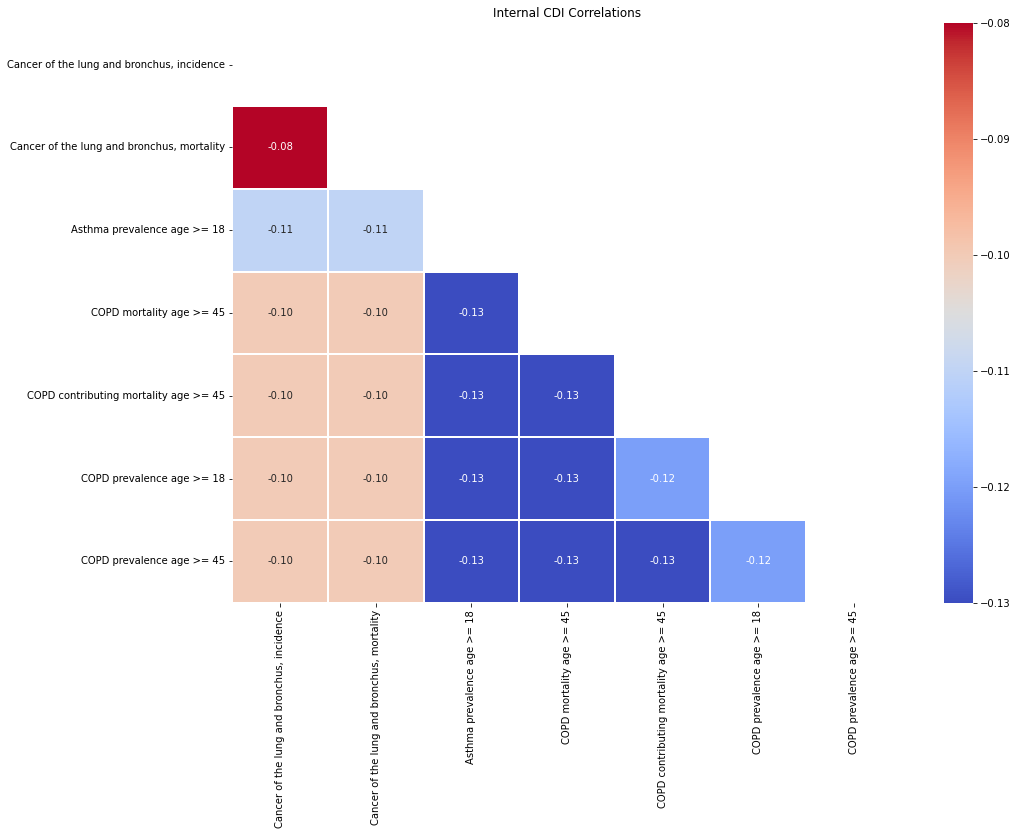

In [24]:
# limit to disease measures only
corrmat = cdi_df.iloc[:,1:9].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(15, 10))
_ = sns.heatmap(round(corrmat,2), annot=True, mask=mask, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05).set_title('Internal CDI Correlations')
f.subplots_adjust(top=0.93);

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='group'></a>
## 1.3 Grouping CDI and AQI Dataframes

We'll group the CDI data by state and take the average over the years in which the data was collected for that state.

In [25]:
aqi_by_state_year = aqi_df.groupby(['State', 'Year'])[['Days with AQI', 'Good Days',
       'Moderate Days', 'Unhealthy for Sensitive Groups Days',
       'Unhealthy Days', 'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days SO2', 'Days PM2.5', 'Days PM10']].mean()

cdi_by_state_year = cdi_df.groupby(['State', 'Year']).mean()

cdi_by_state_year

Cancer of the lung and bronchus, incidence  \
State   Year                                               
Alabama 2008                                   42.450000   
        2009                                   41.850000   
        2010                                   20.750000   
        2011                                    9.155556   
        2012                                    9.133333   
...                                                  ...   
Wyoming 2016                                    0.000000   
        2017                                    0.000000   
        2018                                    0.000000   
        2019                                    0.000000   
        2020                                    0.000000   

              Cancer of the lung and bronchus, mortality  \
State   Year                                               
Alabama 2008                                   33.150000   
        2009                                   33.150000   
        2010                                   16.350000   
        2011                                    7.133333   
        2012                                    7.044444   
...                                                  ...   
Wyoming 2016                                    0.000000   
        2017                                    0.000000   
        2018                                    0.000000   
        2019                                    0.000000   
        2020                                    0.000000   

              Asthma prevalence age >= 18  COPD mortality age >= 45  \
State   Year                                                          
Alabama 2008                     0.000000                  0.000000   
        2009                     0.000000                  0.000000   
        2010                     0.000000                 35.625000   
        2011                     0.888889                 16.044444   
        2012                     0.955556                 16.366667   
...                                   ...                       ...   
Wyoming 2016                     1.357143                 19.200000   
        2017                     1.300000                 21.385714   
        2018                     1.242857                 23.914286   
        2019                     1.357143                 22.100000   
        2020                     2.000000                  0.000000   

              COPD contributing mortality age >= 45  \
State   Year                                          
Alabama 2008                               0.000000   
        2009                               0.000000   
        2010                              61.225000   
        2011                              27.555556   
        2012                              27.244444   
...                                             ...   
Wyoming 2016                              40.128571   
        2017                              40.800000   
        2018                              46.285714   
        2019                              46.257143   
        2020                               0.000000   

              COPD prevalence age >= 18  COPD prevalence age >= 45  \
State   Year                                                         
Alabama 2008                   0.000000                   0.000000   
        2009                   0.000000                   0.000000   
        2010                   0.000000                   0.000000   
        2011                   1.066667                   1.455556   
        2012                   1.100000                   1.588889   
...                                 ...                        ...   
Wyoming 2016                   1.000000                   1.457143   
        2017                   0.957143                   1.471429   
        2018                   0.914286                   1.442857   
        2019                   0.971429   

Let's look at the missing cancer data.

In [26]:
cancer_missing = cdi_by_state_year[(cdi_by_state_year['Cancer of the lung and bronchus, incidence']) <= 0 |
                  (cdi_by_state_year['Cancer of the lung and bronchus, mortality'] <= 0)].reset_index()

cancer_missing.Year.value_counts()

2015    51
2016    51
2017    51
2018    51
2019    51
2020    51
2008     1
2009     1
2010     1
2011     1
2012     1
2013     1
2014     1
Name: Year, dtype: int64

From this it's clear that all states are missing study values from 2015-2020. Cancer studies are actually four years in term, so we'll distribute the values of the last study (ending in 2014 out to 2018).

In [27]:
## Extend 2014 cancer trial out to 2018
# incidence rows
cdi_by_state_year['Cancer of the lung and bronchus, incidence'] = cdi_by_state_year['Cancer of the lung and bronchus, incidence'].replace(0,np.nan)
cdi_by_state_year['Cancer of the lung and bronchus, incidence'] = cdi_by_state_year['Cancer of the lung and bronchus, incidence'].fillna(method="ffill", limit=4)
cdi_by_state_year['Cancer of the lung and bronchus, incidence'] = cdi_by_state_year['Cancer of the lung and bronchus, incidence'].replace(np.nan,0)
# mortality
cdi_by_state_year['Cancer of the lung and bronchus, mortality'] = cdi_by_state_year['Cancer of the lung and bronchus, mortality'].replace(0,np.nan)
cdi_by_state_year['Cancer of the lung and bronchus, mortality'] = cdi_by_state_year['Cancer of the lung and bronchus, mortality'].fillna(method="ffill", limit=4)
cdi_by_state_year['Cancer of the lung and bronchus, mortality'] = cdi_by_state_year['Cancer of the lung and bronchus, mortality'].replace(np.nan,0)

# count again to see that fill worked
cancer_missing = cdi_by_state_year[(cdi_by_state_year['Cancer of the lung and bronchus, incidence']) <= 0 |
                  (cdi_by_state_year['Cancer of the lung and bronchus, mortality'] <= 0)].reset_index()

cancer_missing.Year.value_counts()

2019    51
2020    51
2008     1
2009     1
2010     1
2011     1
2012     1
2013     1
2014     1
2015     1
2016     1
2017     1
2018     1
Name: Year, dtype: int64

Great - that is what we are expecting. There is no imputable data for 2019 or 2020 for all states. The other missing values are simply states that have incomplete reported data:

In [28]:
cancer_missing[cancer_missing.Year.isin([2008,2009,2010,2011,2012,2013,2014])] 

State  Year  Cancer of the lung and bronchus, incidence  \
56  Nevada  2008                                         0.0   
57  Nevada  2009                                         0.0   
58  Nevada  2010                                         0.0   
59  Nevada  2011                                         0.0   
60  Nevada  2012                                         0.0   
61  Nevada  2013                                         0.0   
62  Nevada  2014                                         0.0   

    Cancer of the lung and bronchus, mortality  Asthma prevalence age >= 18  \
56                                   48.500000                       0.0000   
57                                   48.100000                       0.0000   
58                                   16.066667                       0.0000   
59                                    6.025000                       1.0125   
60                                    5.887500                       0.9250   
61                                    5.800000                       0.9500   
62                                    5.575000                       1.0125   

    COPD mortality age >= 45  COPD contributing mortality age >= 45  \
56                  0.000000                                 0.0000   
57                  0.000000                                 0.0000   
58                 37.833333                                59.3000   
59                 14.625000                                23.6625   
60                 15.700000                                24.8750   
61                 16.475000                                26.2250   
62                 16.425000                                25.9250   

    COPD prevalence age >= 18  COPD prevalence age >= 45  \
56                     0.0000                     0.0000   
57                     0.0000                     0.0000   
58                     0.0000                     0.0000   
59                     0.9125                     1.4500   
60                     0.9375                     1.6000   
61                     0.8375                     1.2250   
62                     0.8625                     1.3625   

    smoking and COPD prevalence age >= 18  ...  Texas  Utah  Vermont  \
56                                  0.000  ...    0.0   0.0      0.0   
57                                  0.000  ...    0.0   0.0      0.0   
58                                  0.000  ...    0.0   0.0      0.0   
59                                  4.875  ...    0.0   0.0      0.0   
60                                  3.900  ...    0.0   0.0      0.0   
61                                  5.275  ...    0.0   0.0      0.0   
62                                  4.325  ...    0.0   0.0      0.0   

    Virginia  Washington  West Virginia  Wisconsin  Wyoming   Longitude  \
56       0.0         0.0            0.0        0.0      0.0 -117.071841   
57       0.0         0.0            0.0        0.0      0.0 -117.071841   
58       0.0         0.0            0.0        0.0      0.0 -117.071841   
59       0.0         0.0            0.0        0.0      0.0 -117.071841   
60       0.0         0.0            0.0        0.0      0.0 -117.071841   
61       0.0         0.0            0.0        0.0      0.0 -117.071841   
62       0.0         0.0            0.0        0.0      0.0 -117.071841   

    Latitude  
56  39.49324  
57  39.49324  
58  39.49324  
59  39.49324  
60  39.49324  
61  39.49324  
62  39.49324  

[7 rows x 64 columns]

Below is the correlation matrix of grouped CDI data.

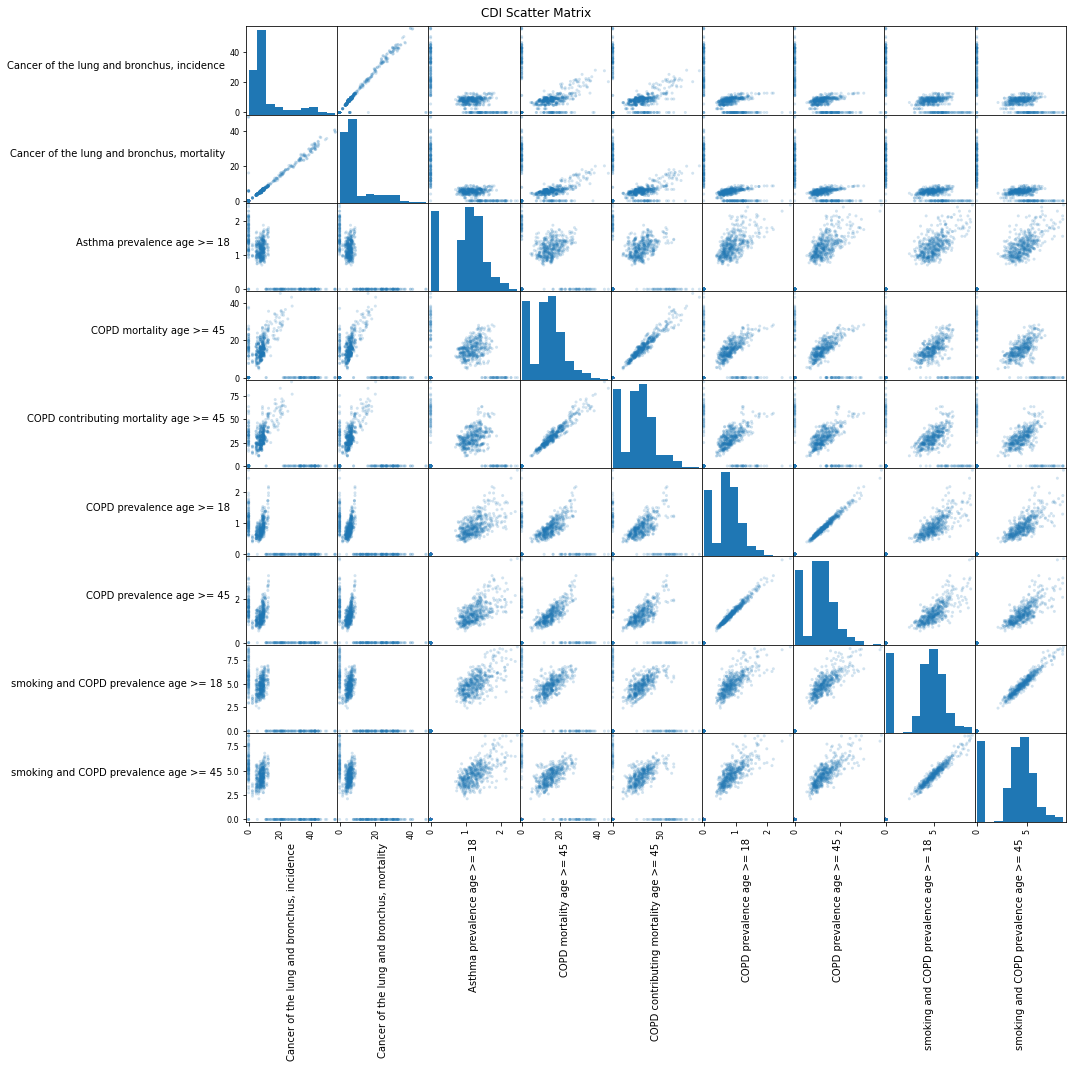

In [29]:
# remove state data - we'll plot that seperately
temp = cdi_by_state_year.iloc[:,0:9]

axes = pd.plotting.scatter_matrix(temp, alpha=0.2, figsize=(15,15))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.suptitle('CDI Scatter Matrix', verticalalignment='center')
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

There look to be very close correlations between cancer and COPD. As well as with asthma and COPD. Asthma might be weakly correlated with cancer. But asthma and COPD look to correlate well.

Let's concentrate on the distrubutions of the disease data.

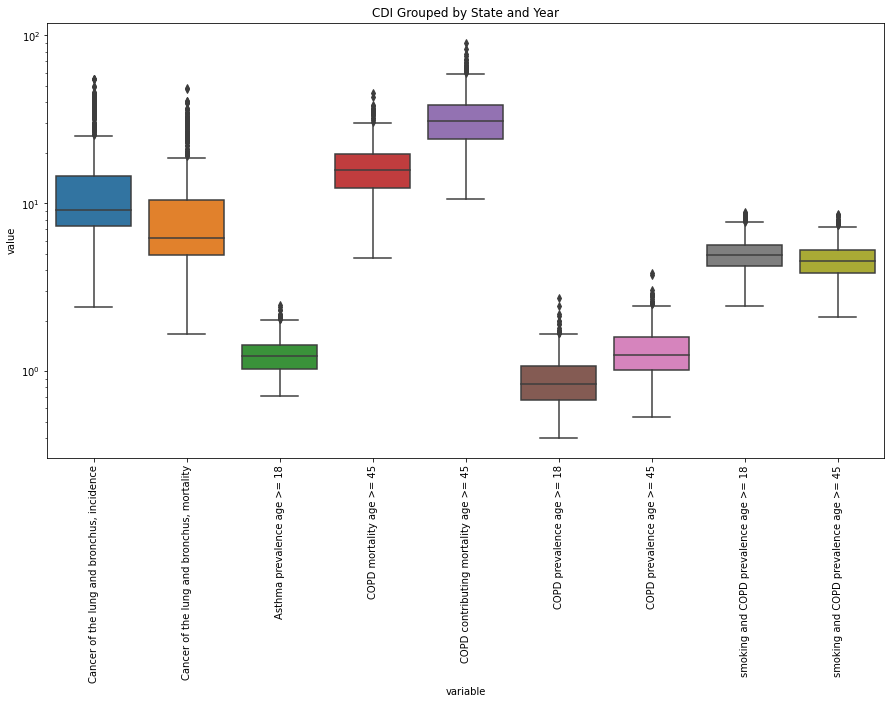

In [30]:
# only plot the disease measures - replace zero with Nan so that lower 
# confidence interval doesn't 'bottom out'
temp = cdi_by_state_year.iloc[:,0:9].replace(0,np.nan)
plt.subplots(figsize=(15, 8))
g = sns.boxplot(x="variable", y="value", data=pd.melt(temp))
g.set_title('CDI Grouped by State and Year')
g.set_yscale('log')
plt.xticks(rotation='vertical');

Overall, the diseases have a tight IQR spread, however there are a disproportionate amount of extreme values for cancer.

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='merge'></a>
## 1.4 Merging CDI and AQI Dataframes

Now that we've looked at our data sources seperately, its time to merge them and see what information can be gained.

In [31]:
merged_df = aqi_by_state_year.merge(cdi_by_state_year, left_index=True, right_index=True, how='left')
merged_df.sample(10)

Days with AQI  Good Days  Moderate Days  \
State         Year                                            
New Jersey    2016     344.562500   0.763207       0.220850   
Wyoming       2014     319.833333   0.868687       0.128726   
Nevada        2013     309.555556   0.687772       0.273766   
Ohio          2008     302.536585   0.682885       0.277235   
Tennessee     2009     291.800000   0.783451       0.203254   
Delaware      2017     363.666667   0.782061       0.206056   
Vermont       2008     283.250000   0.842701       0.150375   
Missouri      2009     289.857143   0.728568       0.247224   
New Hampshire 2010     342.571429   0.772291       0.179778   
Kentucky      2013     308.724138   0.843876       0.153885   

                    Unhealthy for Sensitive Groups Days  Unhealthy Days  \
State         Year                                                        
New Jersey    2016                             0.014910        0.001033   
Wyoming       2014                             0.001674        0.000913   
Nevada        2013                             0.021707        0.009682   
Ohio          2008                             0.037720        0.002161   
Tennessee     2009                             0.013154        0.000141   
Delaware      2017                             0.011882        0.000000   
Vermont       2008                             0.006924        0.000000   
Missouri      2009                             0.021562        0.002646   
New Hampshire 2010                             0.044398        0.003532   
Kentucky      2013                             0.002239        0.000000   

                    Very Unhealthy Days  Hazardous Days     Max AQI  \
State         Year                                                    
New Jersey    2016             0.000000        0.000000  137.812500   
Wyoming       2014             0.000000        0.000000   96.888889   
Nevada        2013             0.002811        0.004262  230.333333   
Ohio          2008             0.000000        0.000000  139.487805   
Tennessee     2009             0.000000        0.000000  114.750000   
Delaware      2017             0.000000        0.000000  122.333333   
Vermont       2008             0.000000        0.000000  107.250000   
Missouri      2009             0.000000        0.000000  120.714286   
New Hampshire 2010             0.000000        0.000000  134.571429   
Kentucky      2013             0.000000        0.000000   94.034483   

                    90th Percentile AQI  Median AQI  ...  Texas  Utah  \
State         Year                                   ...                
New Jersey    2016            62.937500   39.625000  ...    0.0   0.0   
Wyoming       2014            49.611111   35.944444  ...    0.0   0.0   
Nevada        2013            69.777778   41.000000  ...    0.0   0.0   
Ohio          2008            76.682927   41.146341  ...    0.0   0.0   
Tennessee     2009            59.450000   35.800000  ...    0.0   0.0   
Delaware      2017            61.000000   41.333333  ...    0.0   0.0   
Vermont       2008            51.250000   30.500000  ...    0.0   0.0   
Missouri      2009            66.380952   40.857143  ...    0.0   0.0   
New Hampshire 2010            70.142857   40.285714  ...    0.0   0.0   
Kentucky      2013            53.137931   38.000000  ...    0.0   0.0   

                    Vermont  Virginia  Washington  West Virginia  Wisconsin  \
State         Year                                                            
New Jersey    2016      0.0       0.0         0.0            0.0        0.0   
Wyoming       2014      0.0       0.0         0.0            0.0        0.0   
Nevada        2013      0.0       0.0         0.0            0.0        0.0   
Ohio          2008      0.0       0.0         0.0            0.0        0.0   
Tennessee     2009      0.0       0.0         0.0            0.0        0.0   
Delaware      2017      0.0       0.0         0.0            0.0        0.0   


Plot AQI vs CDI measures overall first

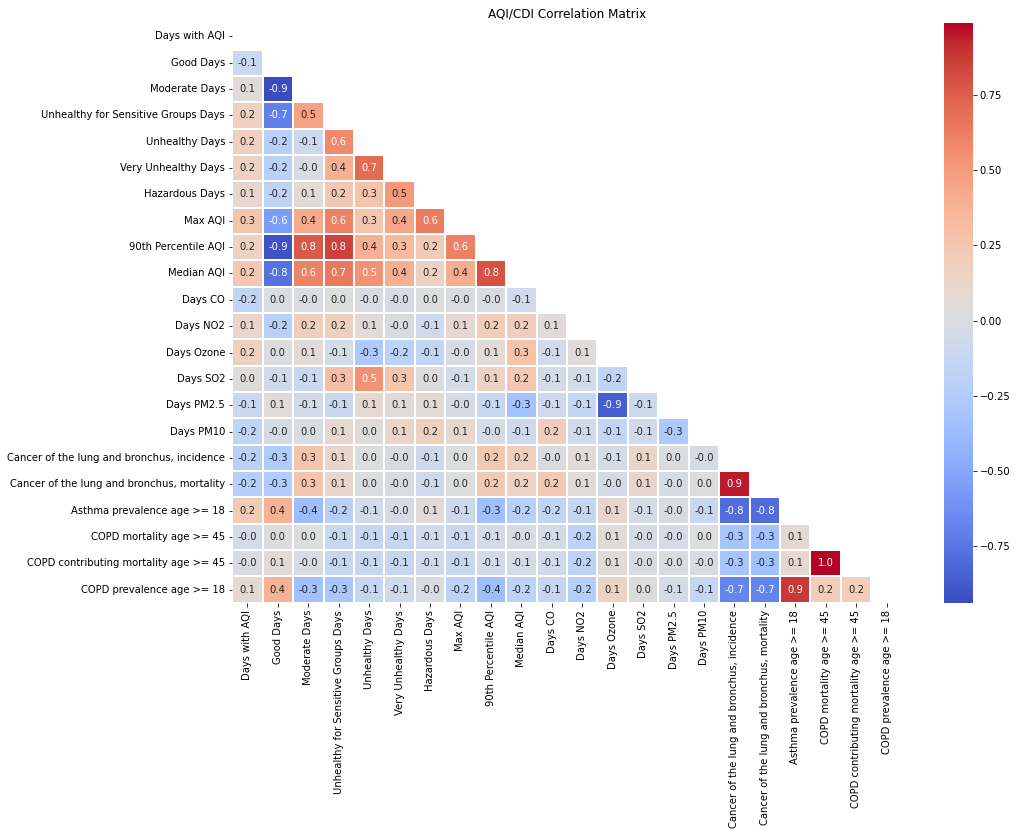

In [32]:
# ignoring state data
corrmat = merged_df.iloc[:,:22].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(15, 10))
_ = sns.heatmap(round(corrmat,2), annot=True, mask=mask, ax=ax, cmap="coolwarm",fmt='.1f', linewidths=.05).set_title("AQI/CDI Correlation Matrix")
f.subplots_adjust(top=0.93);

Interestingly, AQI 'Good Days' are positively correlated with Asthma prevalence and with COPD prevalence - but (weakly) negatively correlated with Cancer incidence and mortality. As we progress towards worse AQI measures, the COPD prevalences actually invert to negative correlations, getting smaller in magnitude as we approach 'Hazardous Days'. COPD mortality looks to be uncorrelated to AQI. Cancer incidence and mortality is positively correlated to 'Moderate Days', but again the effect diminishes as AQI gets worse. 

I'm not sure what causes these effects. They're counterintuitive to what I would expect. Maybe its an artifact of the relative sizes of the set of good vs the others. The number of good days is more than the number of moderate days as so on down to Hazardous days. There may be some lurking or confounding evidence here. But for now, I am accepting that data as it is.

Asthma prevalence is tighly correlated with COPD prevalence. But cancer incidence and mortality are strongly negatively correlated with both COPD and Asthma prevalences, as well as to (to a lesser but still significant way) COPD mortality.

The COPD correlation is also surprising. I would definitely expect a positive correlation between lung cancers and COPD. But it appears that Asthma and COPD are more likely to be co-morbidities. And both Asthma and COPD seem to be mutually exclusive to lung cancers.

Let's look at AQI day classifications now and see how they correlate to each state.

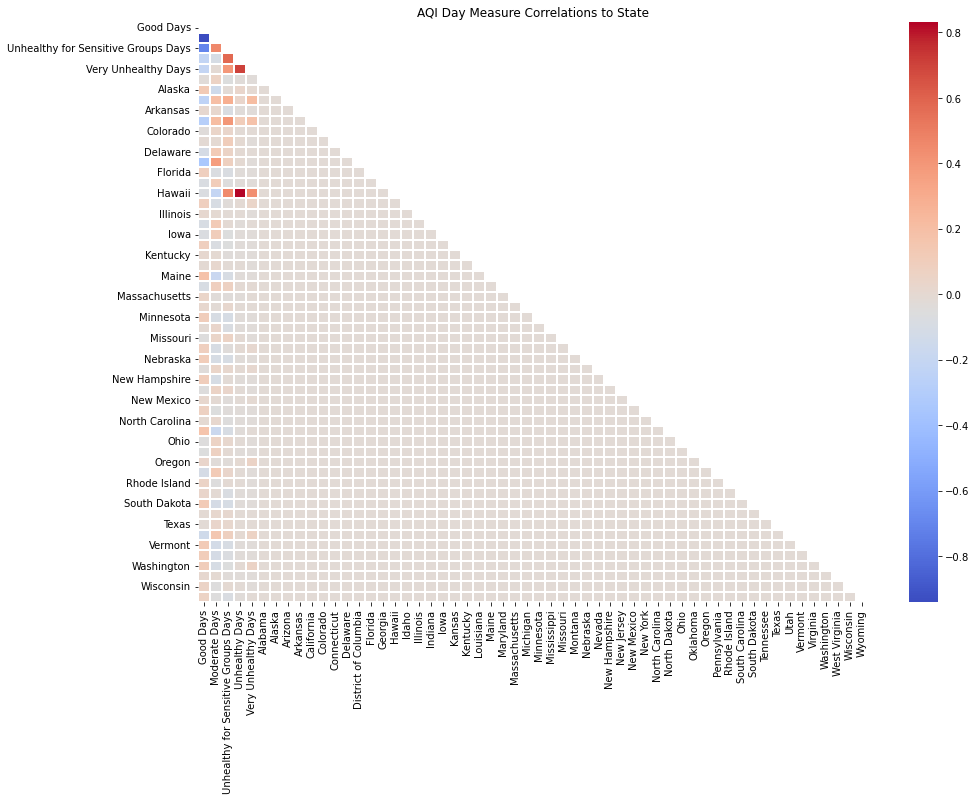

In [33]:
# state data
corrmat = merged_df.iloc[:,np.r_[1:6, 25:76]].corr() # not sure why second slice can't use '25:' notation
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(15, 10))
_ = sns.heatmap(round(corrmat,2), annot=False, mask=mask, ax=ax, cmap="coolwarm",fmt='.1f', linewidths=.05).set_title("AQI Day Measure Correlations to State")
f.subplots_adjust(top=0.93);

That's pretty dense to look at visually, but it goes an overview. It looks like Hawaii has a lot of 'Unhealthy' days. But then so do Arkansas and California. Remember that the AQI classifications take many factors into account, so that we are not necessarily comparing apples to apples when it comes to pollution.

let's break these numbers out to see row states rank with regard to the AQI classifications (averaged over the year).

State correlations with 'Good Days'

In [34]:
corrmat = merged_df.corr()
temp = corrmat.unstack().unstack()[25:-2]
temp.loc[:,'Good Days'].sort_values(ascending=False)

Maine                   0.183625
North Dakota            0.173496
Alaska                  0.125344
Vermont                 0.124902
South Dakota            0.118844
Virginia                0.111268
Nebraska                0.109691
Minnesota               0.102423
Washington              0.101521
New Hampshire           0.099341
Montana                 0.090557
Idaho                   0.086922
Kansas                  0.086839
Florida                 0.085628
New York                0.067861
Wyoming                 0.064412
Rhode Island            0.053762
Wisconsin               0.045109
Massachusetts           0.039329
Oregon                  0.031165
South Carolina          0.029154
New Mexico              0.023787
Michigan                0.017165
Kentucky                0.011119
West Virginia           0.010651
Arkansas                0.006387
Illinois                0.005666
North Carolina         -0.000234
Mississippi            -0.006168
Louisiana              -0.008265
Tennessee 

State correlations with 'Moderate Days'

In [35]:
temp.loc[:,'Moderate Days'].sort_values(ascending=False)

District of Columbia    0.370280
California              0.210246
Arizona                 0.203545
Utah                    0.146855
Pennsylvania            0.122634
Delaware                0.122367
Indiana                 0.116701
Georgia                 0.105600
Iowa                    0.100839
Maryland                0.089034
Oklahoma                0.073946
Ohio                    0.063000
Alabama                 0.055408
New Jersey              0.051182
Missouri                0.044613
Colorado                0.042798
Nevada                  0.040081
Mississippi             0.030404
Texas                   0.027575
Louisiana               0.019009
Tennessee               0.017928
Arkansas                0.017419
North Carolina          0.016761
Illinois                0.002902
Kentucky                0.002899
West Virginia           0.000125
Connecticut            -0.003026
South Carolina         -0.010415
New Mexico             -0.013733
Michigan               -0.017648
Massachuse

State correlations with 'Unhealthy for Sensitive Groups Days'

In [36]:
temp.loc[:,'Unhealthy for Sensitive Groups Days'].sort_values(ascending=False)

Hawaii                  0.454743
California              0.398534
Arizona                 0.289938
Connecticut             0.099085
District of Columbia    0.081180
Utah                    0.075833
Maryland                0.066689
Missouri                0.059231
Delaware                0.054890
New Jersey              0.029427
Colorado                0.028996
Pennsylvania            0.025826
Ohio                    0.023317
Texas                   0.022190
Nevada                  0.020509
Michigan                0.018512
Tennessee               0.007172
Wisconsin              -0.001136
Rhode Island           -0.005459
Indiana                -0.010101
Oklahoma               -0.014799
Illinois               -0.018002
Alaska                 -0.018054
New Hampshire          -0.018073
Louisiana              -0.020879
Idaho                  -0.025194
West Virginia          -0.027968
Oregon                 -0.029649
Massachusetts          -0.037005
Montana                -0.037314
New York  

State correlations with 'Unhealthy Days'

In [37]:
temp.loc[:,'Unhealthy Days'].sort_values(ascending=False)

Hawaii                  0.828091
California              0.111555
Arizona                 0.027288
Alaska                  0.027081
Oregon                  0.002587
Connecticut             0.000845
District of Columbia    0.000168
Utah                   -0.001046
Missouri               -0.005085
Idaho                  -0.005674
Montana                -0.005920
Washington             -0.006823
Maryland               -0.009661
Delaware               -0.011543
Nevada                 -0.014577
Texas                  -0.017489
New Jersey             -0.018205
Louisiana              -0.020672
Wisconsin              -0.021430
Rhode Island           -0.021778
Illinois               -0.022408
Colorado               -0.022688
Michigan               -0.022754
Pennsylvania           -0.023198
Tennessee              -0.023325
Ohio                   -0.024502
New Mexico             -0.024808
New Hampshire          -0.025196
North Dakota           -0.025315
Wyoming                -0.025664
Massachuse

State correlations with 'Very Unhealthy Days'

In [38]:
temp.loc[:,'Very Unhealthy Days'].sort_values(ascending=False)

Hawaii                  0.426852
Arizona                 0.211070
California              0.180707
Utah                    0.057123
Oregon                  0.049416
Washington              0.045279
Idaho                   0.039421
Montana                 0.012405
Nevada                  0.008754
Alaska                  0.002260
New Mexico              0.001703
Maryland               -0.009423
Wyoming                -0.017893
Colorado               -0.017899
Texas                  -0.018644
Michigan               -0.021243
Delaware               -0.021359
Massachusetts          -0.023547
North Dakota           -0.023793
Indiana                -0.024067
Tennessee              -0.024217
Kentucky               -0.025294
Georgia                -0.025415
New York               -0.025472
Illinois               -0.025553
Nebraska               -0.026260
Wisconsin              -0.026403
North Carolina         -0.027059
Ohio                   -0.027065
Alabama                -0.027164
Virginia  

State correlations with 'Hazardous Days'

In [39]:
temp.loc[:,'Hazardous Days'].sort_values(ascending=False)

Arizona                 0.287427
California              0.228513
Oregon                  0.180150
Nevada                  0.130834
Hawaii                  0.128009
New Mexico              0.116746
Washington              0.057161
Montana                 0.025934
Alaska                  0.000281
South Dakota           -0.008429
Idaho                  -0.011467
Wyoming                -0.020473
Utah                   -0.024758
Colorado               -0.025171
Texas                  -0.026477
Georgia                -0.027179
New Jersey             -0.028889
New York               -0.028889
Ohio                   -0.028889
Pennsylvania           -0.028889
Oklahoma               -0.028889
North Carolina         -0.028889
New Hampshire          -0.028889
North Dakota           -0.028889
South Carolina         -0.028889
Tennessee              -0.028889
Rhode Island           -0.028889
Nebraska               -0.028889
Virginia               -0.028889
Massachusetts          -0.028889
Missouri  

It appears that 'COPD mortality age >= 45' and 'COPD contributing mortality age >= 45' contain the same correlation values. The same goes for 'COPD prevalence age >= 18' and 'COPD prevalence age >= 45' as well as 'smoking and COPD prevalence age >= 18' and 'smoking and COPD prevalence age >= 45'. To stay consistent with the 'Asthma prevalence age >= 18' column, I'll keep the >= 18 measures and drop the following columns:
- 'COPD mortality age >= 45'
- 'COPD prevalence age >= 45'
- 'smoking and COPD prevalence age >= 45'

In [40]:
merged_df_cols = merged_df.shape[1]
merged_df.drop(['COPD mortality age >= 45','COPD prevalence age >= 45','smoking and COPD prevalence age >= 45'], axis=1, inplace=True)
assert merged_df.shape[1] == merged_df_cols - 3

In [41]:
merged_df.sort_values(by=['State','Year'])

Days with AQI  Good Days  Moderate Days  \
State   Year                                            
Alabama 2008     286.200000   0.647487       0.337735   
        2009     288.133333   0.759017       0.237305   
        2010     294.733333   0.616788       0.367624   
        2011     262.866667   0.700772       0.282139   
        2012     271.285714   0.776745       0.210611   
...                     ...        ...            ...   
Wyoming 2016     328.529412   0.877084       0.122112   
        2017     331.529412   0.790841       0.202068   
        2018     331.055556   0.788808       0.206710   
        2019     344.222222   0.869550       0.126328   
        2020     344.055556   0.862433       0.126288   

              Unhealthy for Sensitive Groups Days  Unhealthy Days  \
State   Year                                                        
Alabama 2008                             0.013580        0.001198   
        2009                             0.003679        0.000000   
        2010                             0.014378        0.001210   
        2011                             0.015756        0.001332   
        2012                             0.011863        0.000781   
...                                           ...             ...   
Wyoming 2016                             0.000643        0.000161   
        2017                             0.005157        0.001450   
        2018                             0.004025        0.000457   
        2019                             0.003666        0.000457   
        2020                             0.008602        0.002277   

              Very Unhealthy Days  Hazardous Days     Max AQI  \
State   Year                                                    
Alabama 2008             0.000000        0.000000  119.733333   
        2009             0.000000        0.000000  104.266667   
        2010             0.000000        0.000000  117.533333   
        2011             0.000000        0.000000  116.000000   
        2012             0.000000        0.000000  111.714286   
...                           ...             ...         ...   
Wyoming 2016             0.000000        0.000000   97.000000   
        2017             0.000322        0.000161  169.411765   
        2018             0.000000        0.000000  107.777778   
        2019             0.000000        0.000000  101.500000   
        2020             0.000248        0.000152  196.666667   

              90th Percentile AQI  Median AQI  ...  Texas  Utah  Vermont  \
State   Year                                   ...                         
Alabama 2008            69.533333   44.133333  ...    0.0   0.0      0.0   
        2009            58.666667   39.333333  ...    0.0   0.0      0.0   
        2010            71.933333   45.933333  ...    0.0   0.0      0.0   
        2011            70.866667   42.466667  ...    0.0   0.0      0.0   
        2012            62.928571   40.214286  ...    0.0   0.0      0.0   
...                           ...         ...  ...    ...   ...      ...   
Wyoming 2016            50.941176   37.000000  ...    0.0   0.0      0.0   
        2017            59.529412   38.470588  ...    0.0   0.0      0.0   
        2018            58.777778   39.555556  ...    0.0   0.0      0.0   
        2019            52.222222   38.833333  ...    0.0   0.0      0.0   
        2020            52.000000   35.555556  ...    0.0   0.0      0.0   

              Virginia  Washington  West Virginia  Wisconsin  Wyoming  \
State   Year                                                            
Alabama 2008       0.0         0.0            0.0        0.0      0.0   
        2009       0.0         0.0            0.0        0.0      0.0   
        2010       0.0         0.0            0.0        0.0      0.0   
        2011       0.0         0.0            0.0        0.0      0.0   
        2012       0.0         0.0            0.0        0.0      0.0   
...                ...      

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='standard'></a>
## 1.5 Standardize Data
Standardize features by removing the mean and scaling to unit variance. This allows us to treat the data as if it were normally distributed.

In [42]:
num_pipeline = Pipeline([
    ('std_scaler', preprocessing.StandardScaler())
])
merged_df[merged_df.columns] = num_pipeline.fit_transform(merged_df)
merged_df.sort_values(by=['State','Year'])

Days with AQI  Good Days  Moderate Days  \
State   Year                                            
Alabama 2008      -0.986944  -1.466906       1.720842   
        2009      -0.927490  -0.326800       0.551916   
        2010      -0.724525  -1.780720       2.068721   
        2011      -1.704497  -0.922197       1.073748   
        2012      -1.445592  -0.145575       0.241227   
...                     ...        ...            ...   
Wyoming 2016       0.314780   0.880136      -0.788823   
        2017       0.407037  -0.001480       0.141795   
        2018       0.392465  -0.022259       0.195826   
        2019       0.797370   0.803116      -0.739755   
        2020       0.792244   0.730367      -0.740223   

              Unhealthy for Sensitive Groups Days  Unhealthy Days  \
State   Year                                                        
Alabama 2008                            -0.042992       -0.164624   
        2009                            -0.606457       -0.226271   
        2010                             0.002410       -0.164000   
        2011                             0.080874       -0.157717   
        2012                            -0.140674       -0.186103   
...                                           ...             ...   
Wyoming 2016                            -0.779223       -0.218001   
        2017                            -0.522321       -0.151638   
        2018                            -0.586757       -0.202776   
        2019                            -0.607200       -0.202776   
        2020                            -0.326251       -0.109114   

              Very Unhealthy Days  Hazardous Days   Max AQI  \
State   Year                                                  
Alabama 2008            -0.203091       -0.204273 -0.082339   
        2009            -0.203091       -0.204273 -0.450583   
        2010            -0.203091       -0.204273 -0.134718   
        2011            -0.203091       -0.204273 -0.171225   
        2012            -0.203091       -0.204273 -0.273264   
...                           ...             ...       ...   
Wyoming 2016            -0.203091       -0.204273 -0.623595   
        2017             0.036438        0.063754  1.100451   
        2018            -0.203091       -0.204273 -0.366988   
        2019            -0.203091       -0.204273 -0.516455   
        2020            -0.018781        0.048172  1.749361   

              90th Percentile AQI  Median AQI  ...     Texas      Utah  \
State   Year                                   ...                       
Alabama 2008             0.875468    1.027625  ... -0.141421 -0.141421   
        2009            -0.105942    0.342048  ... -0.141421 -0.141421   
        2010             1.092221    1.284716  ... -0.141421 -0.141421   
        2011             0.995886    0.789577  ... -0.141421 -0.141421   
        2012             0.278966    0.467873  ... -0.141421 -0.141421   
...                           ...         ...  ...       ...       ...   
Wyoming 2016            -0.803661    0.008782  ... -0.141421 -0.141421   
        2017            -0.028025    0.218823  ... -0.141421 -0.141421   
        2018            -0.095908    0.373788  ... -0.141421 -0.141421   
        2019            -0.687965    0.270634  ... -0.141421 -0.141421   
        2020            -0.708034   -0.197526  ... -0.141421 -0.141421   

               Vermont  Virginia  Washington  West Virginia  Wisconsin  \
State   Year                                                             
Alabama 2008 -0.141421 -0.141421   -0.141421      -0.141421  -0.141421   
        2009 -0.141421 -0.141421   -0.141421      -0.141421  -0.141421   
        2010 -0.141421 -0.141421   -0.141421      -0.141421  -0.141421   
        2011 -0.141421 -0.141421   -0.141421      -0.141421  -0.141421   
        2012 -0.141421 -0.141421   -0.141421      -0.141421  -0.141421   
...                ...       ...         ...            ...        ...   

Lets look at correlations again after standardization.

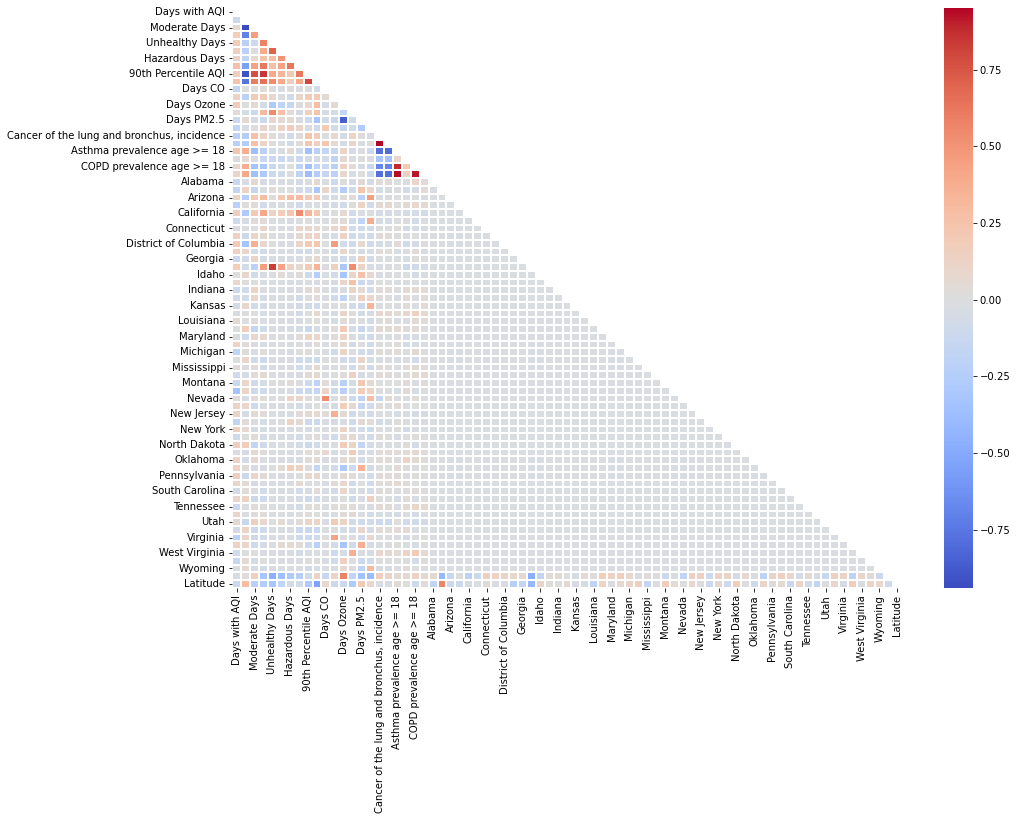

In [43]:
corrmat = merged_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# plot
f, ax = plt.subplots(figsize=(15, 10))
_ = sns.heatmap(round(corrmat,2), annot=False, mask=mask, ax=ax, cmap="coolwarm",fmt='.1f', linewidths=.05)
f.subplots_adjust(top=0.93);

The values comes through a bit brighter now. Although disease correlations with pollution (AQI) by state is still difficult to discriminate.

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='dist'></a>
## 1.6 Finding Data Distributions
Let's look at how our observations are distributed with AQI day categories.

Define a function to plot the PDF and CDF for a given AQI day measure category

In [44]:
def plot_cdf_pdf(x):
    y_pdf = norm.pdf(x)
    y_cdf = norm.cdf(x)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax = [ax, ax.twinx()]
    _ = ax[0].plot(x, y_pdf, label='pdf', color='r')
    _ = ax[1].plot(x, y_cdf, label='cdf', color='b')
    _ = ax[0].tick_params(axis='y', labelcolor='r')
    _ = ax[1].tick_params(axis='y', labelcolor='b')
    _ = ax[0].set_ylabel('pdf', color='r')
    _ = ax[1].set_ylabel('cdf', color='b')
    _ = ax[0].set_title('PDF and CDF of standard normal')

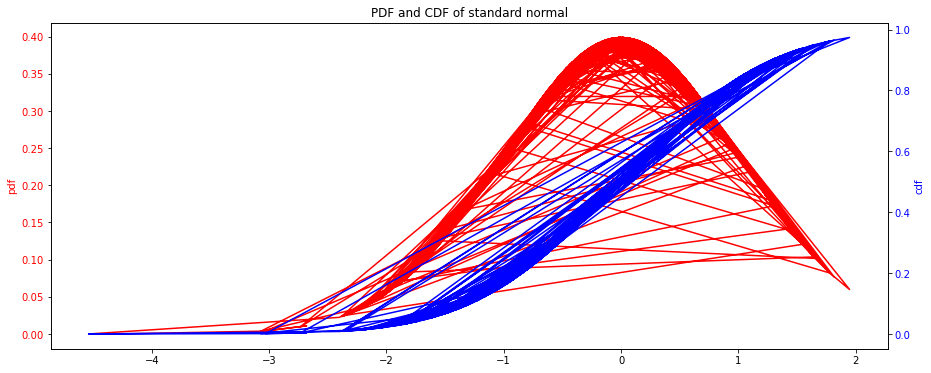

In [45]:
# plot pdf and cdf for 'Good Days'
plot_cdf_pdf(merged_df['Good Days'])

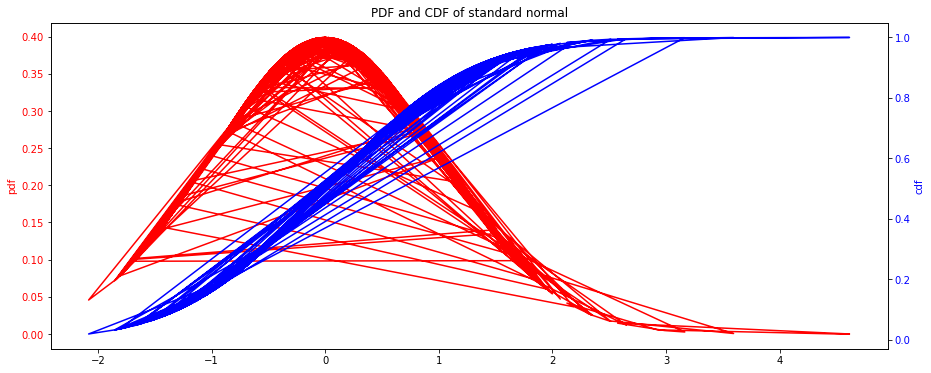

In [46]:
# plot pdf and cdf for 'Moderate Days'
plot_cdf_pdf(merged_df['Moderate Days'])

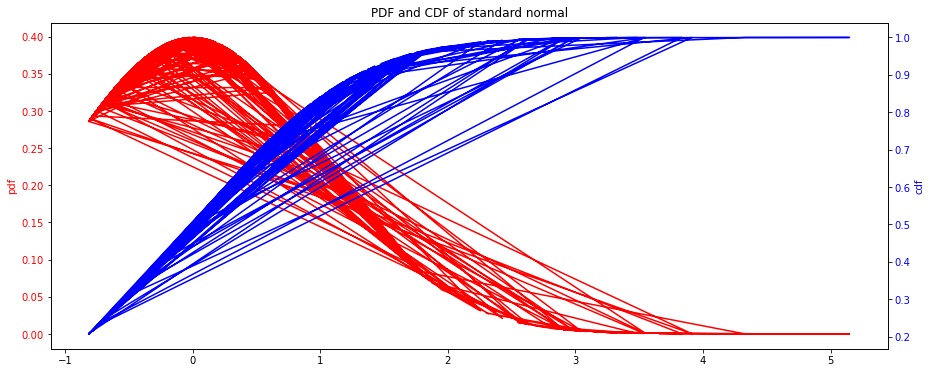

In [47]:
# plot pdf and cdf for 'Unhealthy for Sensitive Groups Days'
plot_cdf_pdf(merged_df['Unhealthy for Sensitive Groups Days'])

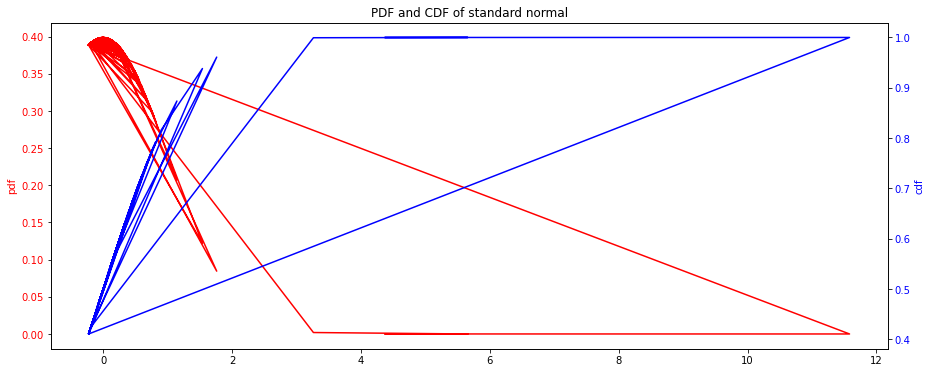

In [48]:
# plot pdf and cdf for 'Unhealthy Days'
plot_cdf_pdf(merged_df['Unhealthy Days'])

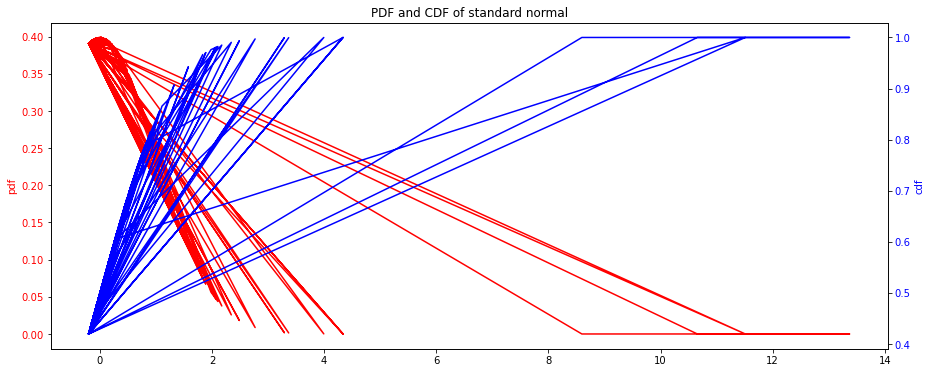

In [49]:
# plot pdf and cdf for 'Very Unhealthy Days'
plot_cdf_pdf(merged_df['Very Unhealthy Days'])

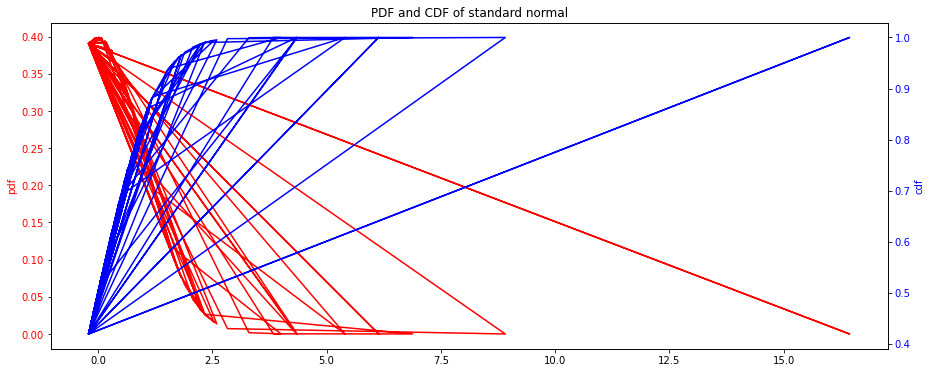

In [50]:
# plot pdf and cdf for 'Hazardous Days'
plot_cdf_pdf(merged_df['Hazardous Days'])

I'm not sure how to interpret the PDF and CDF for observations beyond 'Unhealthy for Sensitive Groups Days'. There are just too few observations to get a feel for the underlying distribution. Perhaps bootstrapping of this data might give us a better picture? 

<a href='#contents' style="float: right;">[back to toc]</a>
<a id='features'></a>
## 1.7 Feature Determination

Lets look closer at the correlations between AQI day classifications and CDI disease questions using a scatter plot matrix.

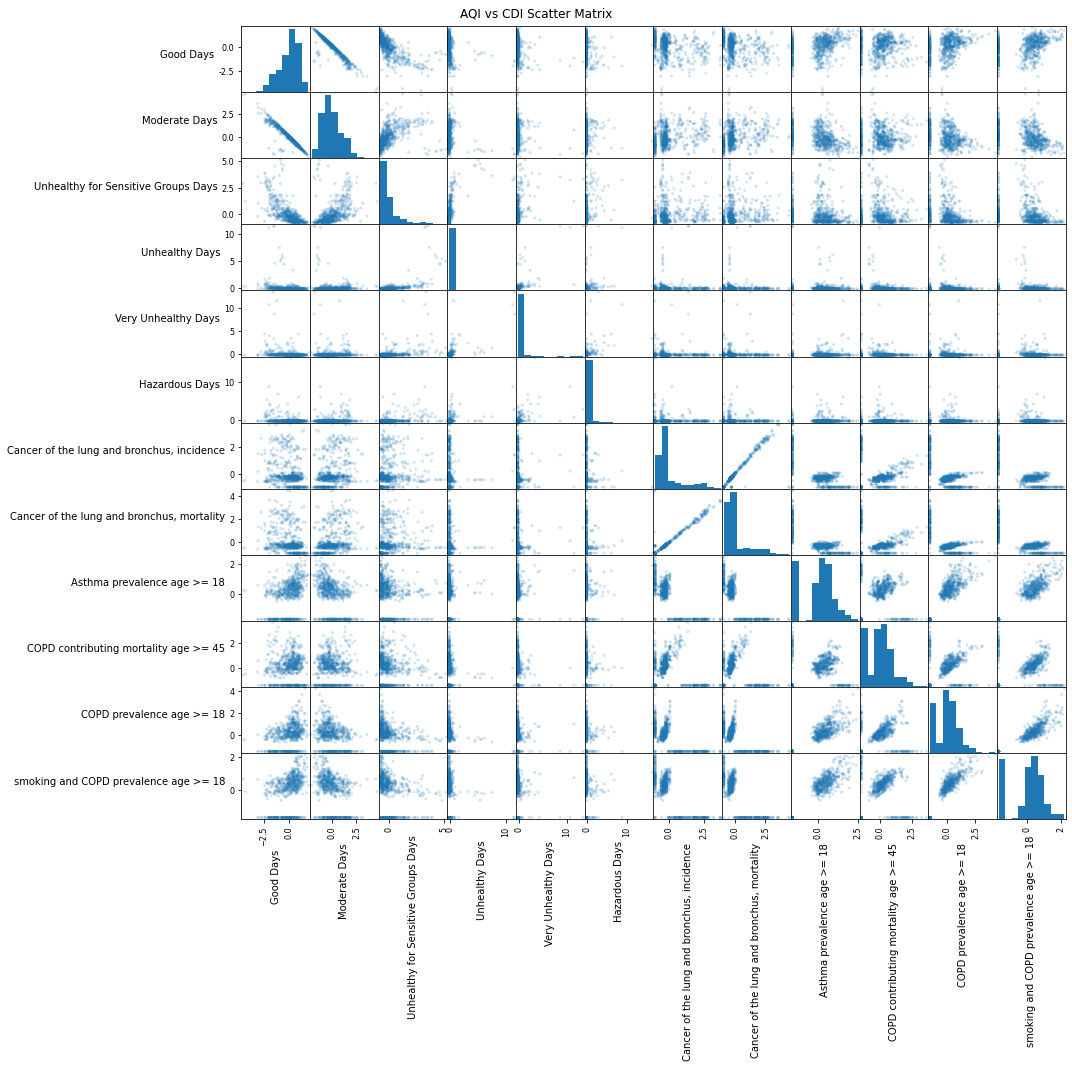

In [51]:
# need a bare-bones dataframe else scatter matrix will be too crowded
scatter_df = merged_df[['Good Days', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days',
       'Cancer of the lung and bronchus, incidence',
       'Cancer of the lung and bronchus, mortality',
       'Asthma prevalence age >= 18', 'COPD contributing mortality age >= 45',
       'COPD prevalence age >= 18', 'smoking and COPD prevalence age >= 18']]

axes = pd.plotting.scatter_matrix(scatter_df, alpha=0.2, figsize=(15,15))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.suptitle('AQI vs CDI Scatter Matrix', verticalalignment='center')
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()


There is a pronounced "mirroring" effect between 'Good Days' and 'Moderate Days' categories. This is likely due to a confounding effect between the categories, where the underlying effect is included in one category and excluded from the other.

There may be a correlation between 'Unhealthy Days', 'Very Unhealthy Days', and 'Hazardous Days' with COPD and asthma. The data points are diffuse though. 

Again, the link between asthma, lung cancers and COPD is coming through loud and clear.

Let's look at how each AQI day category correlates to the CDI diseases.

In [52]:
# slice up merged_df so that we have cols: State, Year, [AQI categories], [CDI disease categories]
observations = pd.concat([merged_df.loc[:,'Good Days':'Hazardous Days'].reset_index(), 
                 merged_df.iloc[:,16:22].reset_index(drop=True)], axis=1)
# melt so that all disease data are long form
melted_observations = observations.melt(id_vars=['State','Year','Good Days','Moderate Days','Unhealthy for Sensitive Groups Days','Unhealthy Days','Very Unhealthy Days','Hazardous Days'], 
        var_name='category', 
        value_name='value')

def plot_cdi_slopes(aqi_cat=None):
    assert aqi_cat != None, 'you must provide an AQI category to plot the CDI diseases against'
    g = sns.lmplot(
        x=aqi_cat, 
        y='value', 
        data=melted_observations,
        palette='bright',
        col="category",
        col_wrap=3,
        facet_kws={'sharex':True, 'sharey':True},
        scatter_kws={'alpha':0.2}, 
        x_jitter=.1, y_jitter=.1,
        hue="category")
    g.fig.suptitle(f'CDI Disease against AQI {aqi_cat}', y=1.0)
    g.fig.subplots_adjust(top=.9, hspace=0.4);

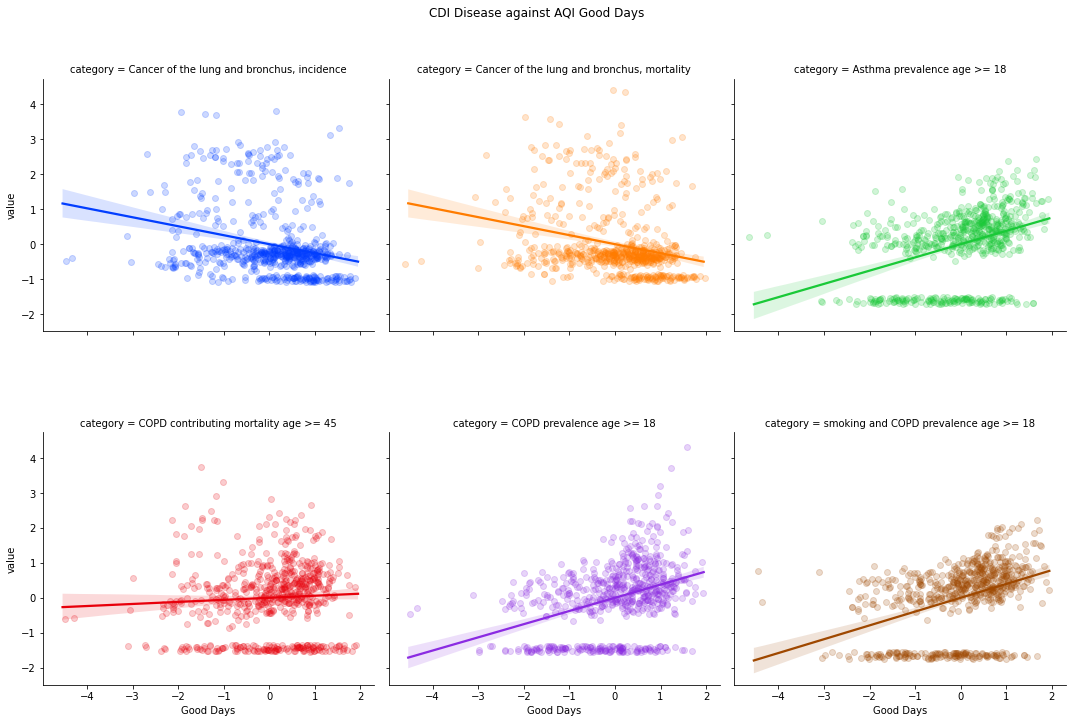

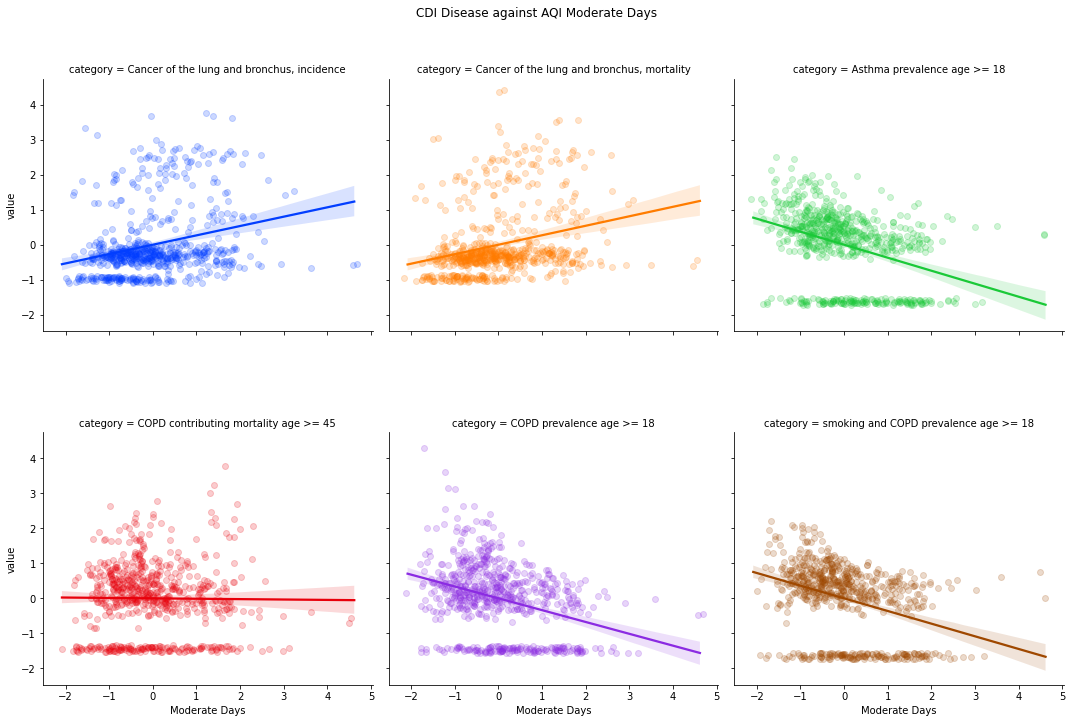

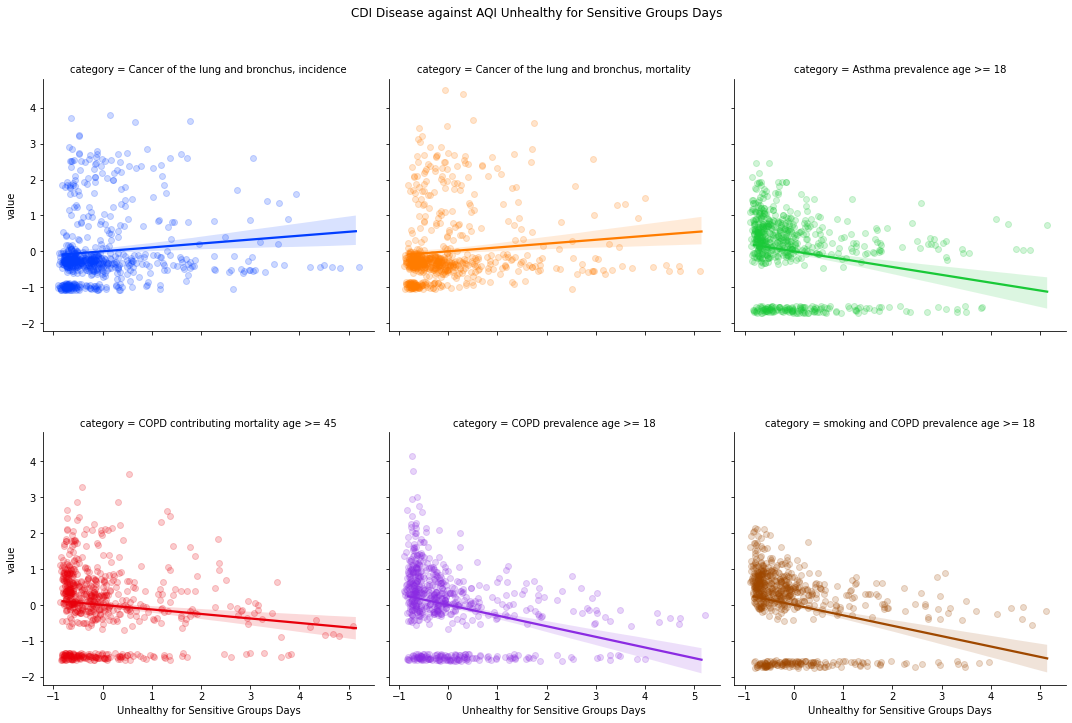

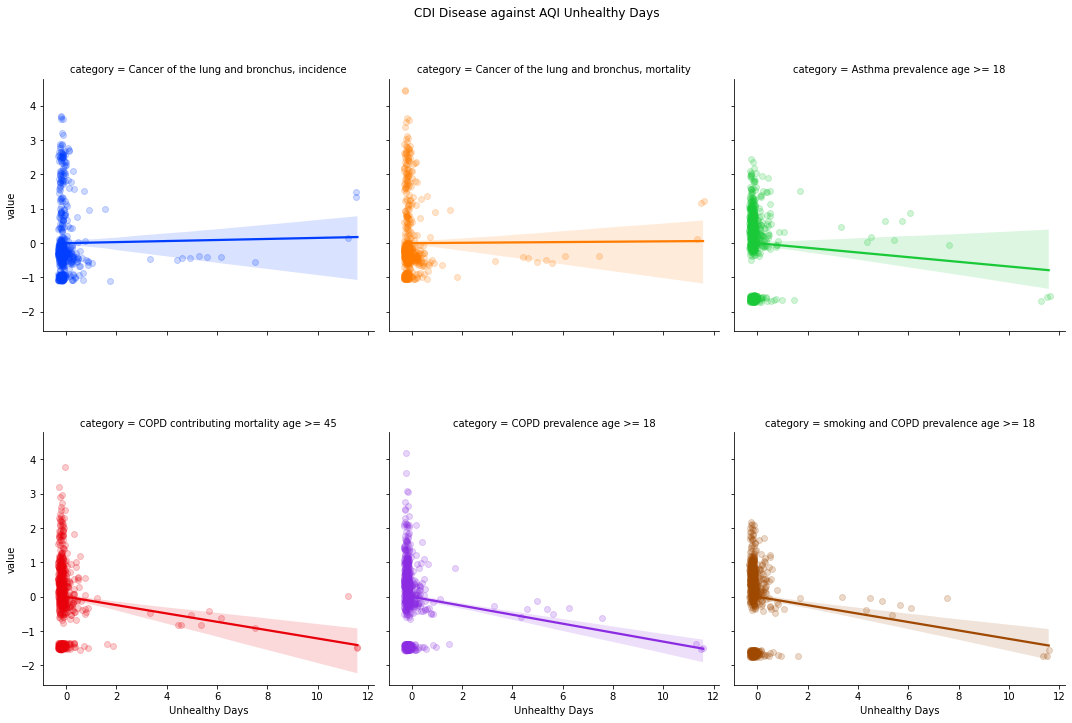

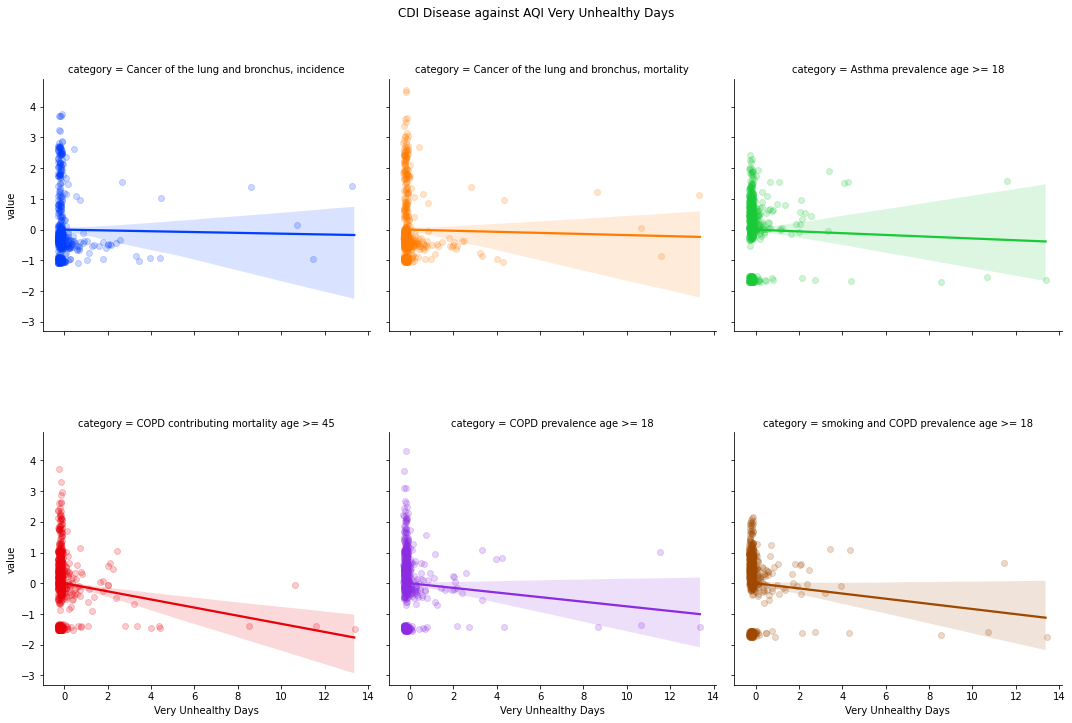

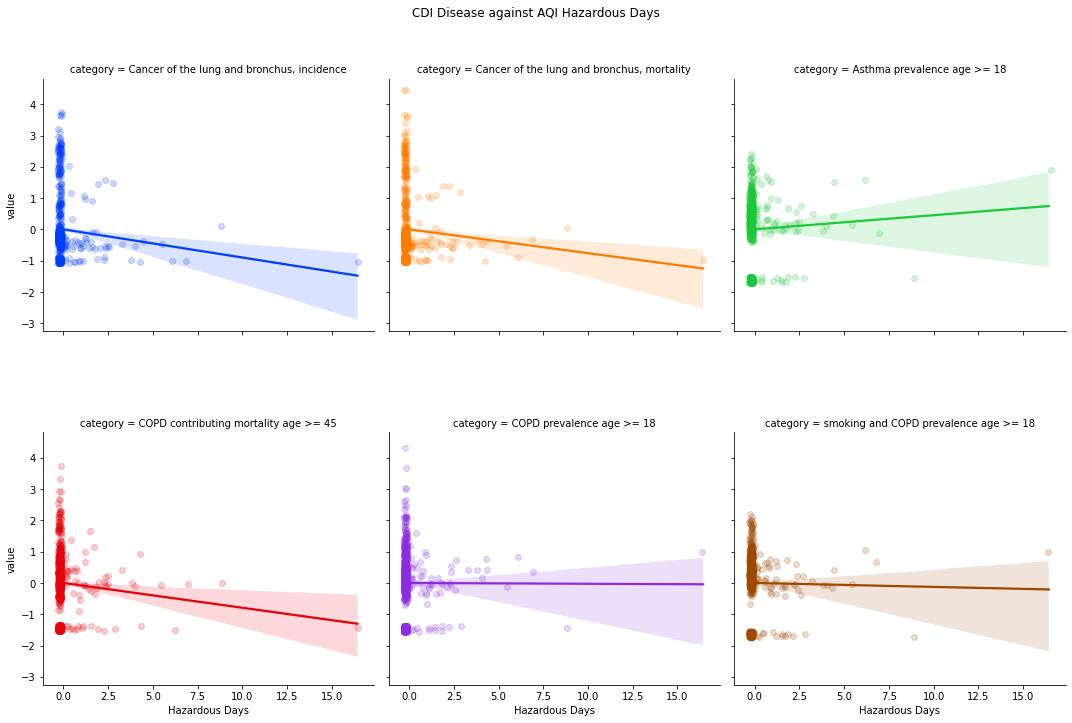

In [53]:
_=[plot_cdi_slopes(aqi) for aqi in merged_df.loc[:,'Good Days':'Hazardous Days']]

Summary:

<table style="width:100%">
   <tr>
       <th colspan="2" style="text-align:center">Positive correlations</th>
   </tr>
  <tr>
    <th style="text-align:left">AQI category</th>
    <th style="text-align:left">CDI disease</th>
  </tr>   
   <tr>
      <td style="text-align:left">Good Days</td>
      <td style="text-align:left">asthma prevalence</td>
   </tr>
   <tr>
      <td style="text-align:left">Good Days</td>
      <td style="text-align:left">COPD mortality (weak)</td>
   </tr>
   <tr>
      <td style="text-align:left">Good Days</td>
      <td style="text-align:left">COPD prevelance</td>
   </tr>
   <tr>
      <td style="text-align:left">Moderate Days</td>
      <td style="text-align:left">cancer</td>
    </tr>
       <tr>
      <td style="text-align:left">Unhealthy for Sensitive Groups Days</td>
      <td style="text-align:left">cancer</td>
   </tr>
       <tr>
      <td style="text-align:left">Hazardous Days</td>
      <td style="text-align:left">asthma prevelance</td>
   </tr>
   <tr>
      <td style="text-align:left">Hazardous Days</td>
      <td style="text-align:left">COPD mortality</td>
   </tr>
</table>


<table style="width:100%">
   <tr>
       <th colspan="2" style="text-align:center">Negative correlations</th>
   </tr>
  <tr>
    <th style="text-align:left">AQI category</th>
    <th style="text-align:left">CDI disease</th>
  </tr>   
   <tr>
      <td style="text-align:left">Good Days</td>
      <td style="text-align:left">cancer</td>
   </tr>
   <tr>
      <td style="text-align:left">Moderate Days</td>
      <td style="text-align:left">asthma prevelance</td>
   </tr>
   <tr>
      <td style="text-align:left">Moderate Days</td>
      <td style="text-align:left">COPD prevelance</td>
   </tr>
   <tr>
      <td style="text-align:left">Unhealthy for Sensitive Groups Days</td>
      <td style="text-align:left">asthma prevelance</td>
    </tr>
       <tr>
      <td style="text-align:left">Unhealthy for Sensitive Groups Days</td>
      <td style="text-align:left">COPD prevelance</td>
   </tr>
       <tr>
      <td style="text-align:left">Unhealthy for Sensitive Groups Days</td>
      <td style="text-align:left">COPD mortality</td>
   </tr>
   <tr>
      <td style="text-align:left">Unhealthy Days</td>
      <td style="text-align:left">asthma prevelance</td>
   </tr>
   <tr>
      <td style="text-align:left">Unhealthy Days</td>
      <td style="text-align:left">COPD</td>
   </tr>
    
   <tr>
      <td style="text-align:left">Very Unhealthy Days</td>
      <td style="text-align:left">COPD</td>
   </tr>
       <tr>
      <td style="text-align:left">Hazardous Days</td>
      <td style="text-align:left">cancer</td>
   </tr>
</table>

Now lets plot the AQI contributing factors

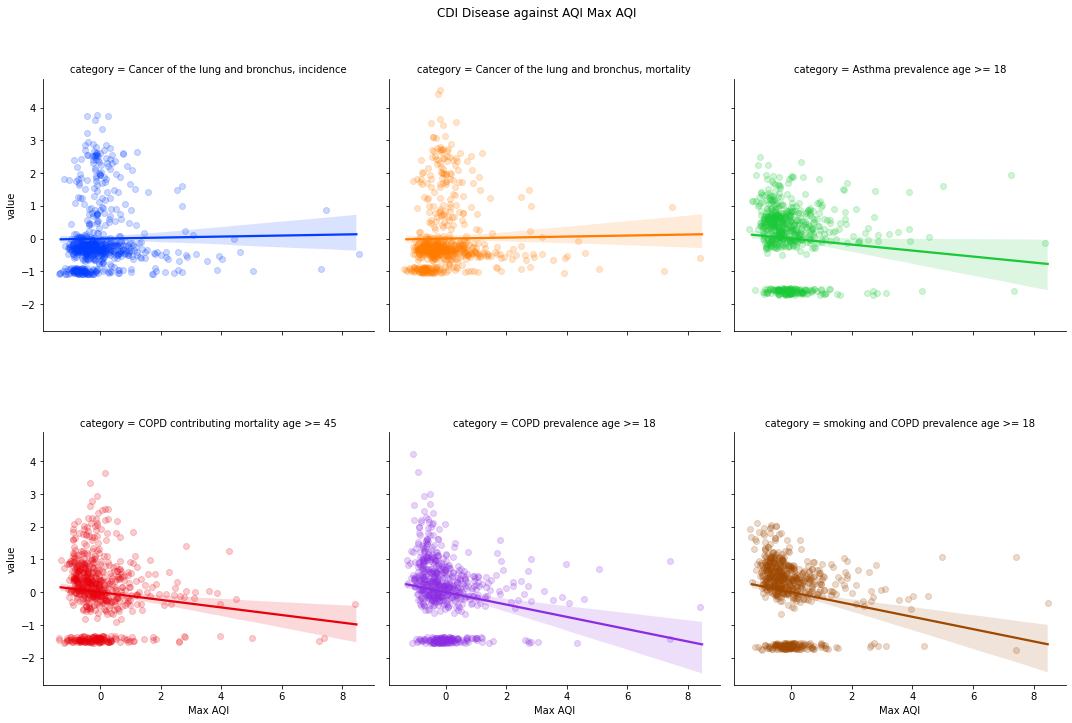

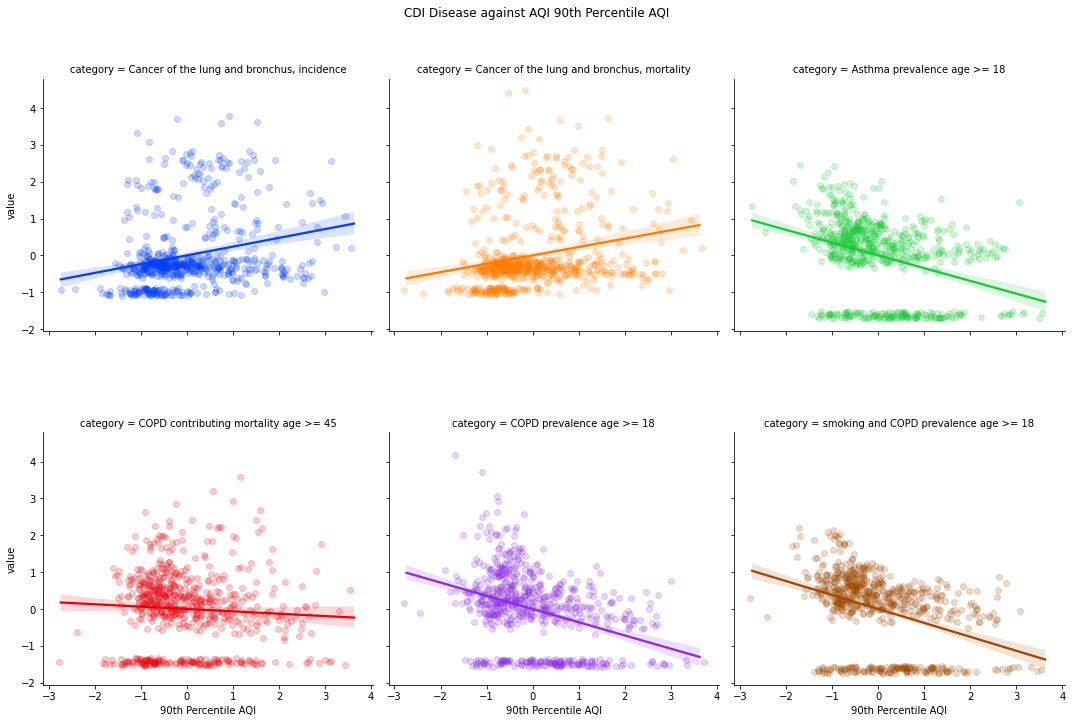

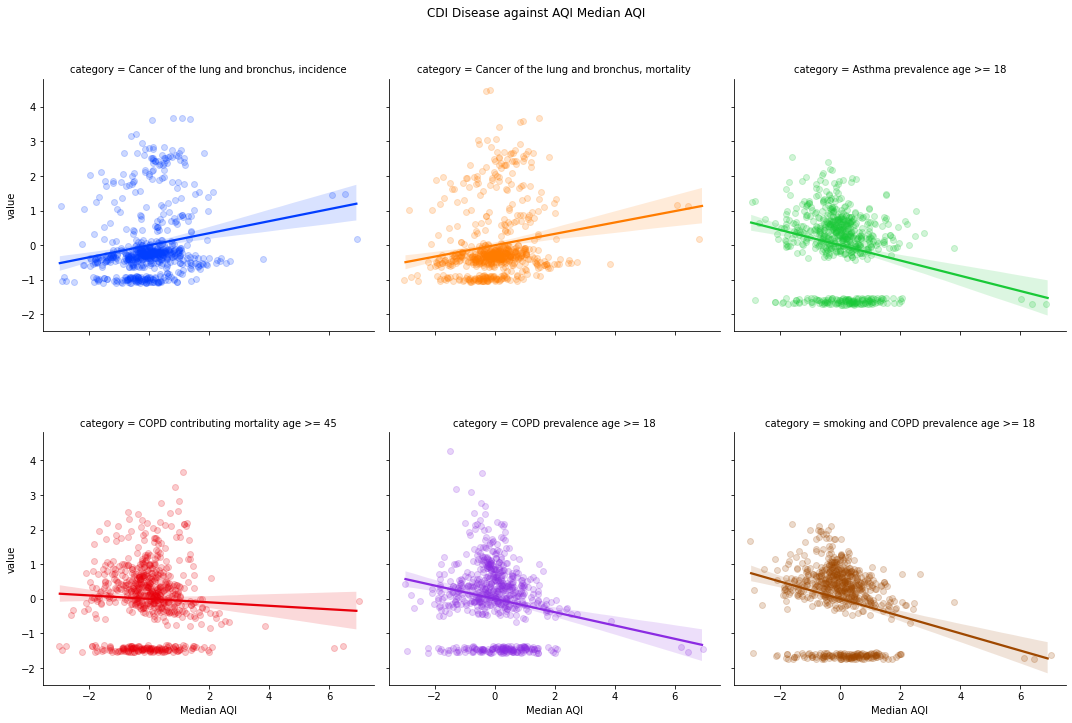

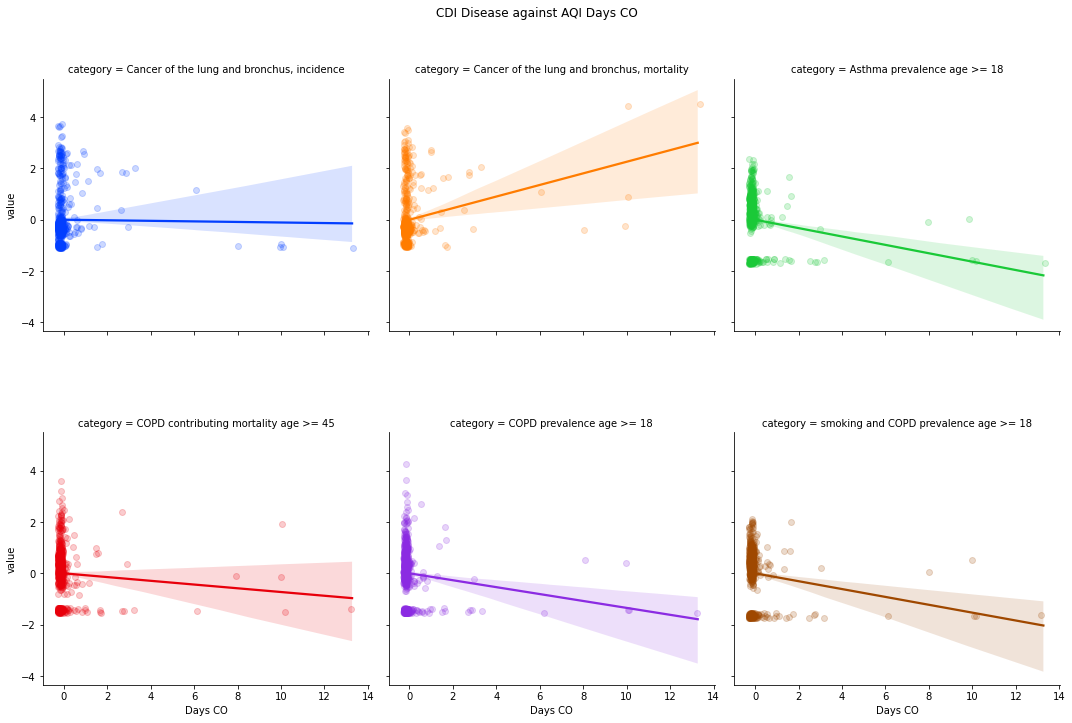

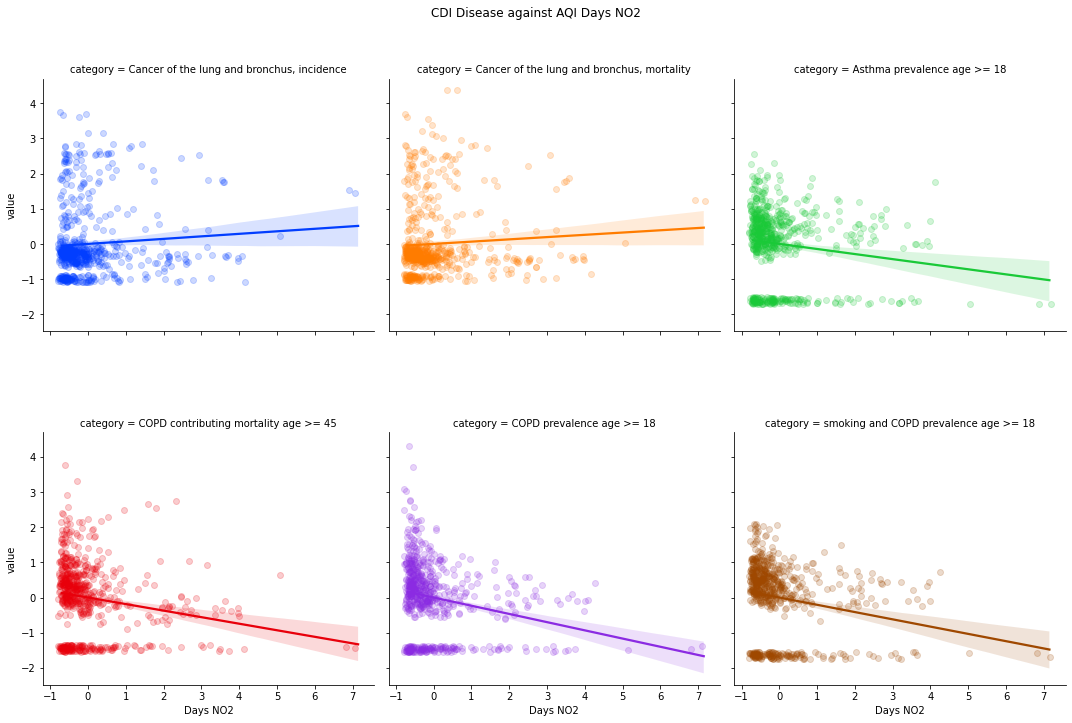

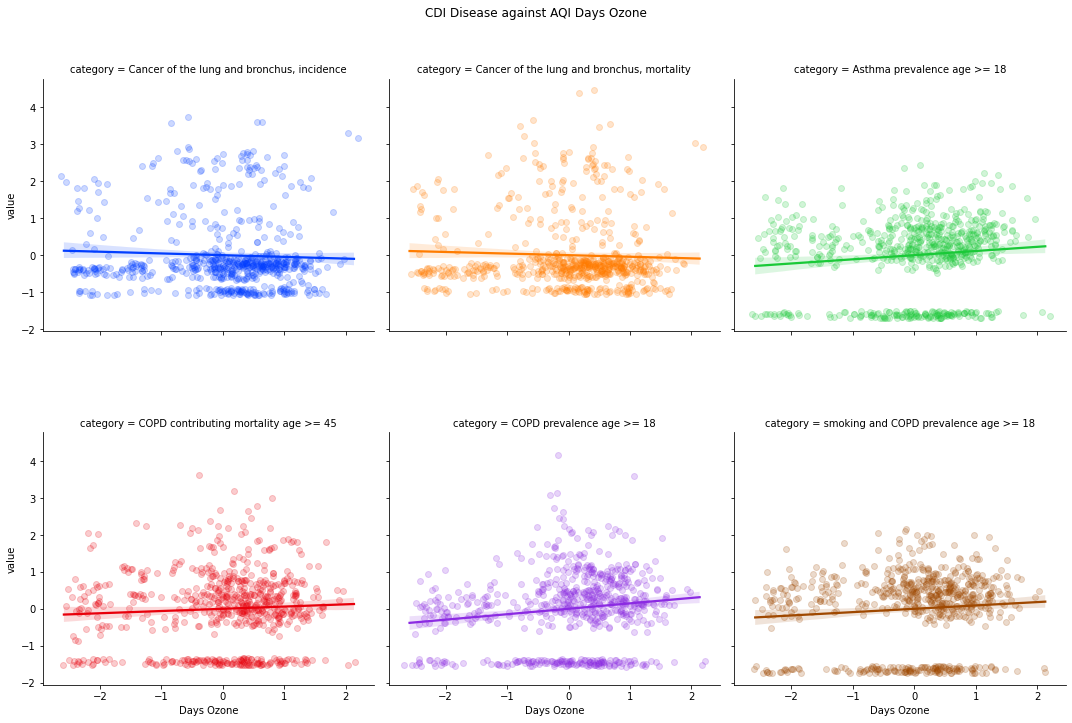

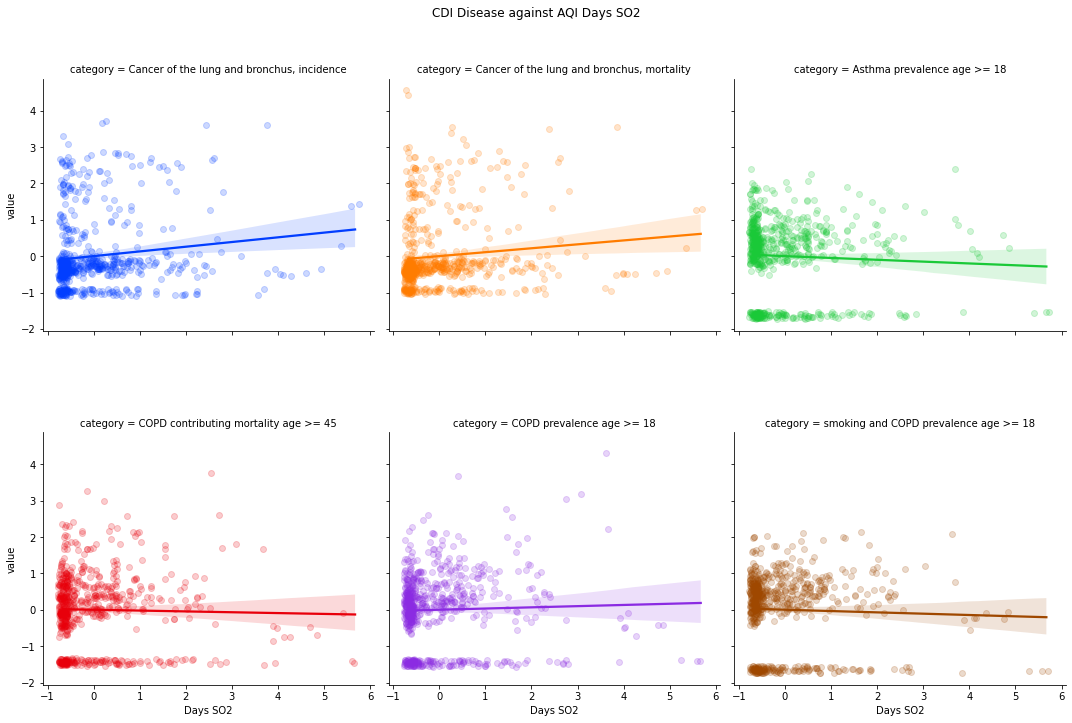

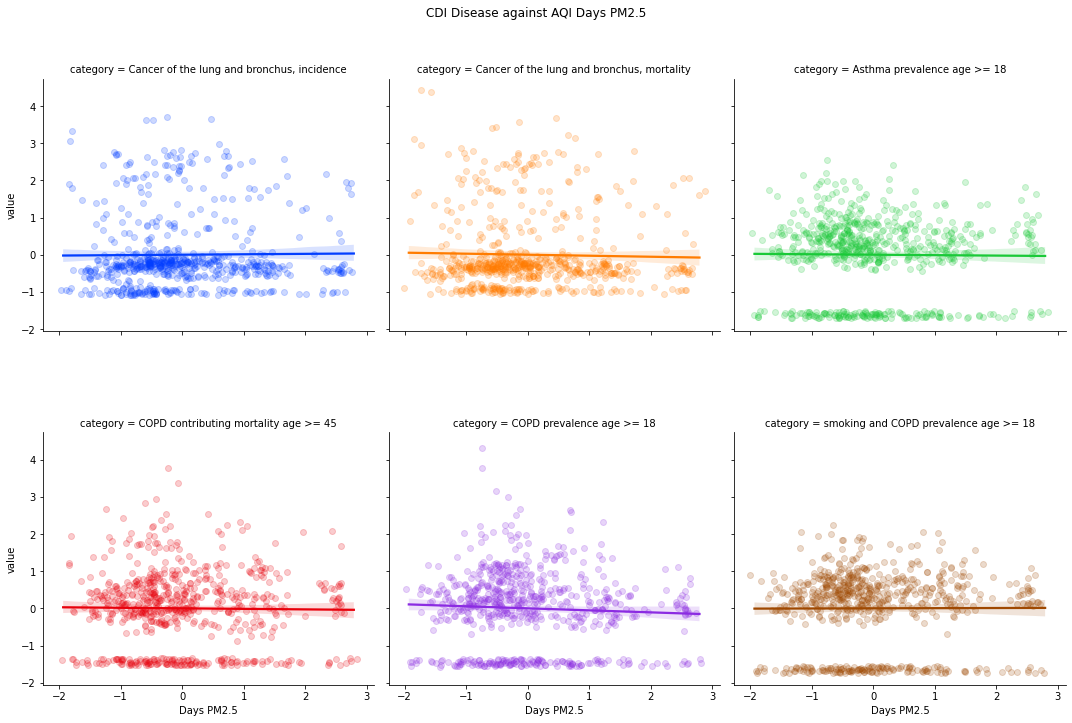

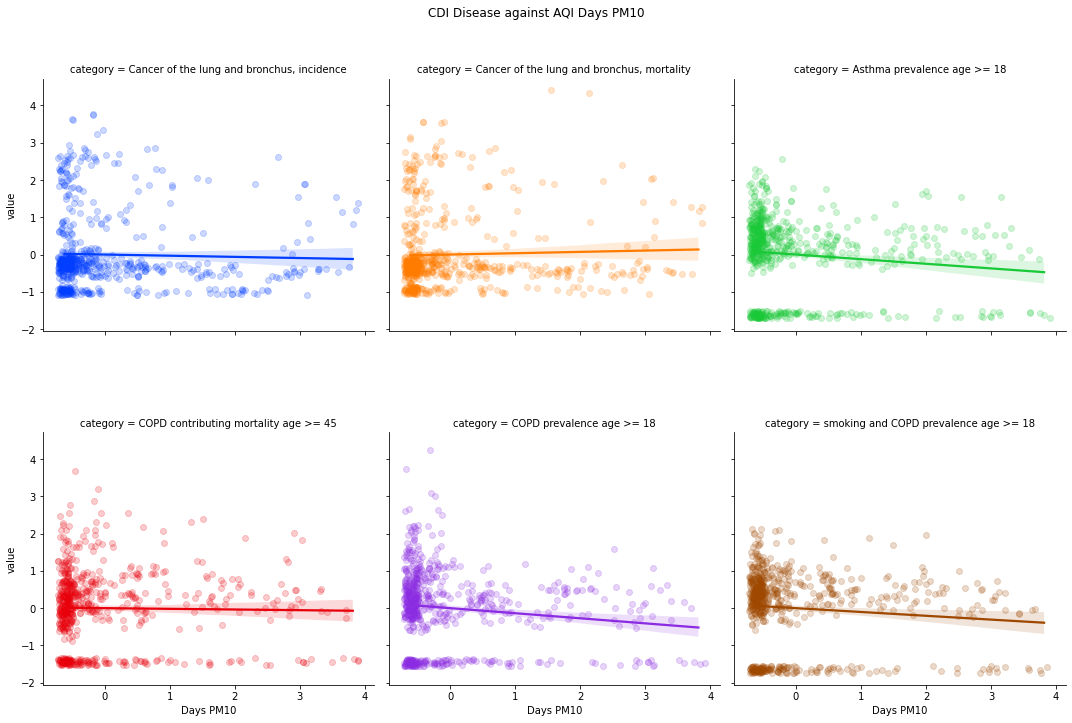

In [54]:
# slice up merged_df so that we have cols: State, Year, [AQI categories], [CDI disease categories]
observations = pd.concat([merged_df.loc[:,'Max AQI':'Days PM10'].reset_index(), 
                 merged_df.iloc[:,16:22].reset_index(drop=True)], axis=1)
# melt so that all disease data are in long form
melted_observations = observations.melt(id_vars=['State','Year','Max AQI','90th Percentile AQI','Median AQI','Days CO','Days NO2','Days Ozone','Days SO2','Days PM2.5','Days PM10'], 
        var_name='category', 
        value_name='value')
_=[plot_cdi_slopes(aqi) for aqi in merged_df.loc[:,'Max AQI':'Days PM10']]


To summarize:

<table style="width:100%">
   <tr>
       <th colspan="2" style="text-align:center">Positive correlations</th>
   </tr>
  <tr>
    <th style="text-align:left">AQI category</th>
    <th style="text-align:left">CDI disease</th>
  </tr>   
   <tr>
      <td style="text-align:left">AQI 90th %</td>
      <td style="text-align:left">cancer</td>
   </tr>
   <tr>
      <td style="text-align:left">AQI median</td>
      <td style="text-align:left">cancer</td>
   </tr>
   <tr>
      <td style="text-align:left">Days CO</td>
      <td style="text-align:left">cancer (mortality, but not incidence)</td>
   </tr>
   <tr>
      <td style="text-align:left">Days NO2</td>
      <td style="text-align:left">cancer (weak)</td>
    </tr> 
    <tr>
      <td style="text-align:left">Days Ozone</td>
      <td style="text-align:left">asthma (weak)</td>
   </tr>
       <tr>
      <td style="text-align:left">Days Ozone</td>
      <td style="text-align:left">COPD (weak)</td>
   </tr>
   <tr>
      <td style="text-align:left">Days SO2</td>
      <td style="text-align:left">cancer (weak)</td>
   </tr>
   <tr>
      <td style="text-align:left">Days PM10</td>
      <td style="text-align:left">cancer mortality (weak)</td>
   </tr>
</table>

 
<table style="width:100%">
   <tr>
       <th colspan="2" style="text-align:center">Negative correlations</th>
   </tr>
  <tr>
    <th style="text-align:left">AQI category</th>
    <th style="text-align:left">CDI disease</th>
  </tr>   
   <tr>
      <td style="text-align:left">AQI Max</td>
      <td style="text-align:left">asthma prevalence</td>
   </tr>
   <tr>
      <td style="text-align:left">AQI Max</td>
      <td style="text-align:left">COPD</td>
   </tr>
   <tr>
      <td style="text-align:left">AQI 90th %</td>
      <td style="text-align:left">asthma prevalence</td>
   </tr>
   <tr>
      <td style="text-align:left">AQI 90th %</td>
      <td style="text-align:left">COPD prevalence</td>
   </tr>
   <tr>
      <td style="text-align:left">AQI median</td>
      <td style="text-align:left">asthma prevalence</td>
   </tr>
   <tr>
      <td style="text-align:left">AQI median</td>
      <td style="text-align:left">COPD</td>
   </tr>
   <tr>
      <td style="text-align:left">Days CO</td>
      <td style="text-align:left">asthma prevalence</td>
   </tr>
   <tr>
      <td style="text-align:left">Days CO</td>
      <td style="text-align:left">COPD)</td>
   </tr>  
   <tr>
      <td style="text-align:left">Days NO2</td>
      <td style="text-align:left">asthma prevalence</td>
    </tr> 
   <tr>
      <td style="text-align:left">Days NO2</td>
      <td style="text-align:left">COPD</td>
    </tr>     
    <tr>
      <td style="text-align:left">Days Ozone</td>
      <td style="text-align:left">cancer (weak)</td>
   </tr>
       <tr>
      <td style="text-align:left">Days SO2</td>
      <td style="text-align:left">asthma prevalence (weak)</td>
   </tr>
   <tr>
      <td style="text-align:left">Days SO2</td>
      <td style="text-align:left">cancer (weak)</td>
   </tr>
   <tr>
      <td style="text-align:left">Days PM10</td>
      <td style="text-align:left">asthma prevalence (weak)</td>
   </tr>
    <tr>
      <td style="text-align:left">Days PM10</td>
      <td style="text-align:left">COPD (weak)</td>
   </tr>
</table>

Lets make a log-log plot of cancer incidence by state to see which states have the highest incidence.

In [55]:
observations = pd.concat([merged_df.loc[:,'Cancer of the lung and bronchus, incidence':'smoking and COPD prevalence age >= 18'].reset_index(), 
                 merged_df.iloc[:,22:-2].reset_index(drop=True)], axis=1)
# melt so that aqi data are long form
melted_observations = observations.melt(id_vars=['State','Year',
                                                 'Cancer of the lung and bronchus, incidence',
                                                 'Cancer of the lung and bronchus, mortality',
                                                 'Asthma prevalence age >= 18',
                                                 'COPD contributing mortality age >= 45',
                                                 'COPD prevalence age >= 18', 
                                                 'smoking and COPD prevalence age >= 18'
                                                ], 
        var_name='category', 
        value_name='value').sort_values(by=['State','Year'])

def plot_state_diseases(disease=None):
    assert disease != None, 'you must provide a CDI disease category to plot against'
    g = sns.lmplot(
        x=disease, 
        y='value', 
        data=melted_observations,
        palette='bright',
        col="category",
        col_wrap=3,
        facet_kws={'sharex':True, 'sharey':True},
        scatter_kws={'alpha':0.2},
        x_jitter=.15, y_jitter=.15
    )
    g.fig.suptitle(f'State against CDI Disease={disease} (log-log)', y=1.0)
    g.fig.subplots_adjust(top=.99, hspace=0.4)
    g.set(xscale="log")
    g.set(yscale="log")
    ;

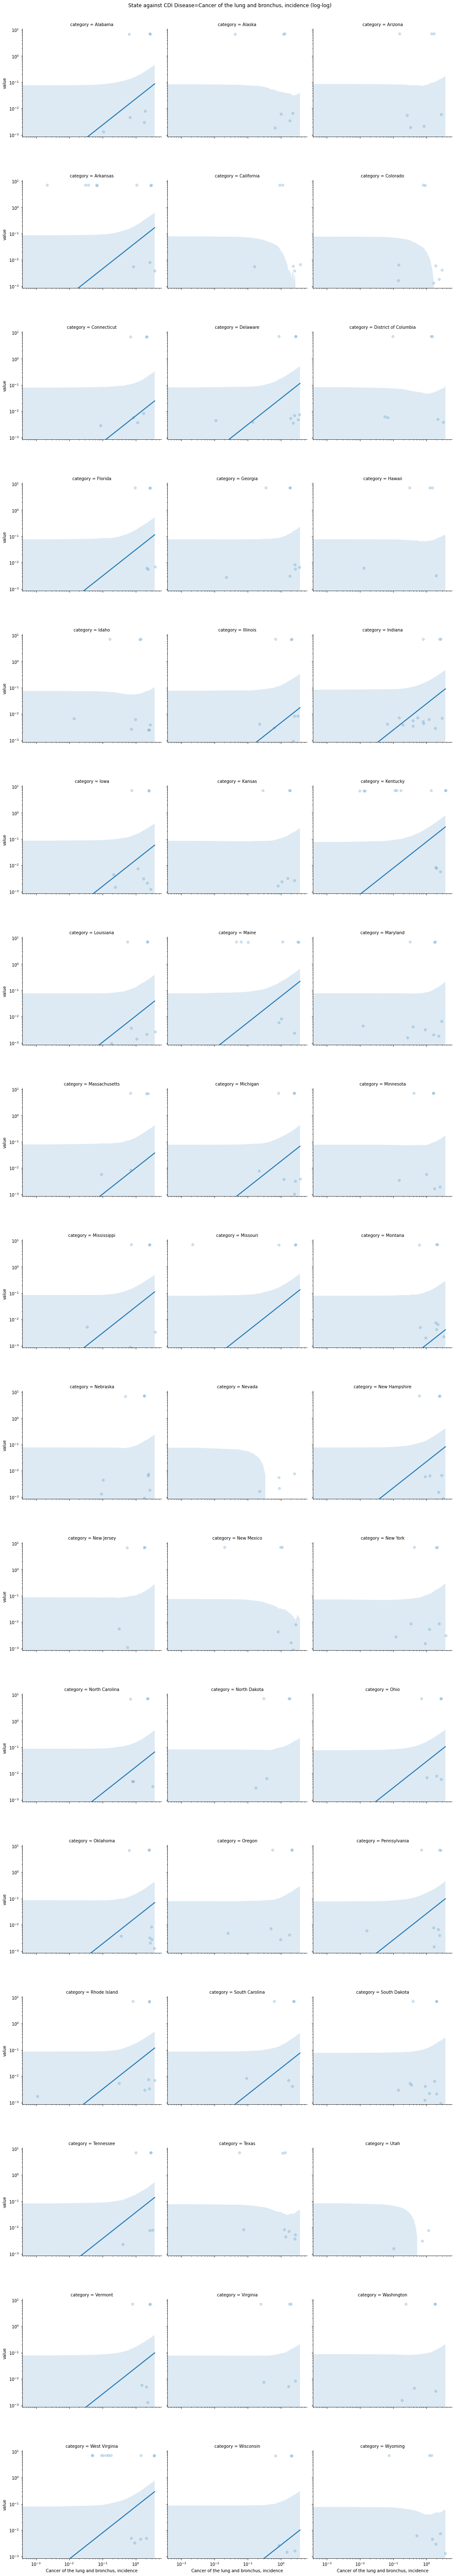

In [56]:
# plot
_=plot_state_diseases('Cancer of the lung and bronchus, incidence')

Let's confirm what we are seeing with a heatmap ordered by the magnitude of the CDI disease values per state (this is an average over time).

In [57]:
corrmat = merged_df.corr()

def state_disease_heatmap(disease=None):
    assert disease, 'a CDC disease category must be provided'
    ci = corrmat.loc[:,'Alaska':'Wyoming'].loc[disease].sort_values(ascending=False).to_frame()
    # plot
    f, ax = plt.subplots(figsize=(15, 10))
    g = sns.heatmap(round(ci,2), annot=False,  ax=ax, cmap="coolwarm",fmt='.1f', linewidths=.05)
    g.set_title(disease)
    f.subplots_adjust(top=0.93);

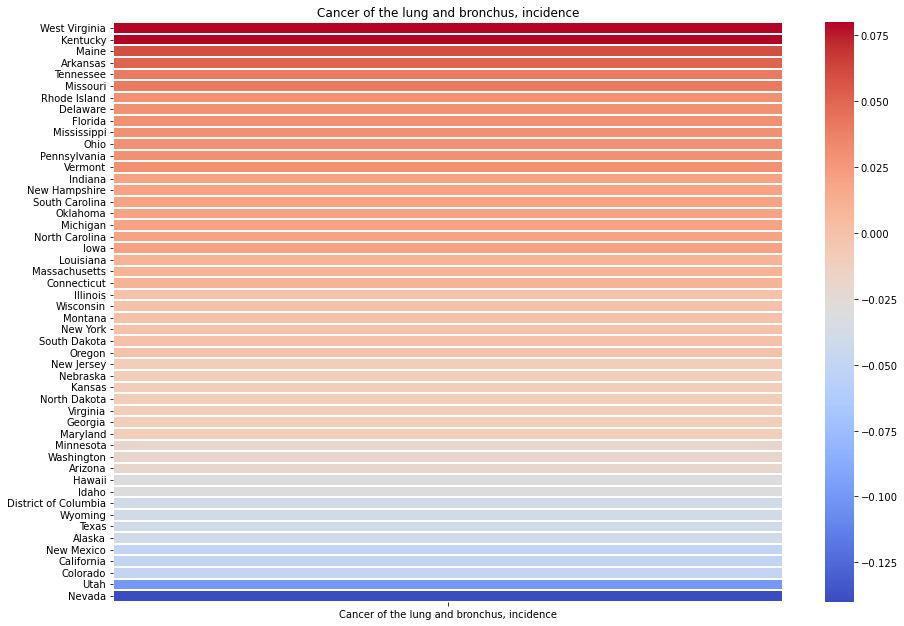

In [58]:
state_disease_heatmap('Cancer of the lung and bronchus, incidence')

Nevada is missing all cancer incidence data, so its ranking should be disregarded here.

'Cancer of the lung and bronchus, mortality'

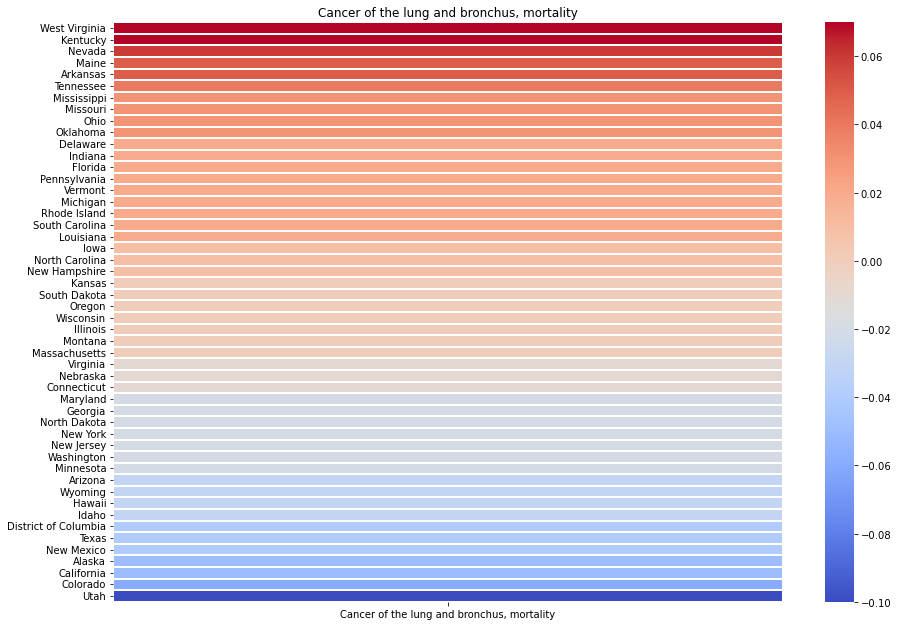

In [59]:
state_disease_heatmap('Cancer of the lung and bronchus, mortality')

'Asthma prevalence age >= 18'

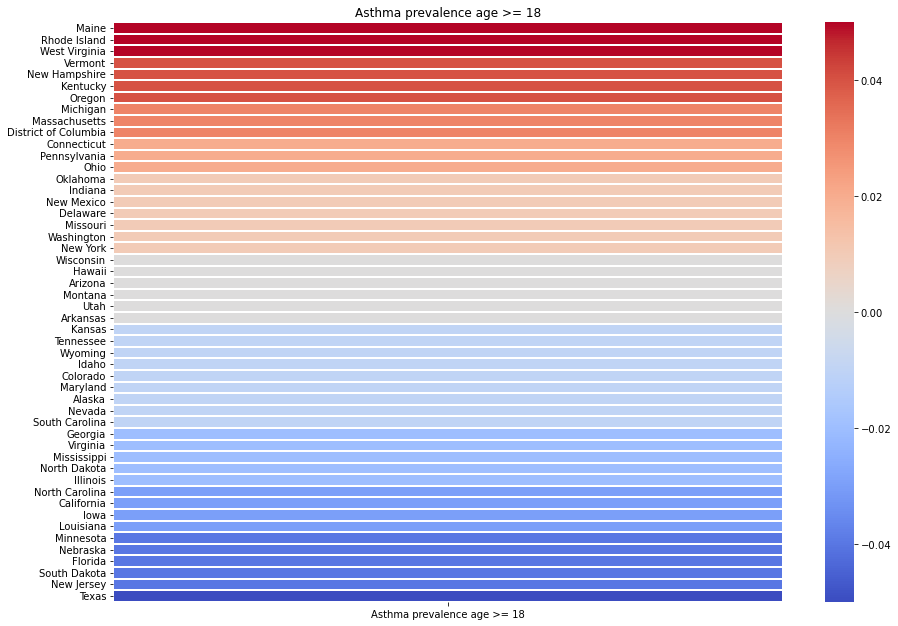

In [60]:
state_disease_heatmap('Asthma prevalence age >= 18')

'COPD contributing mortality age >= 45'

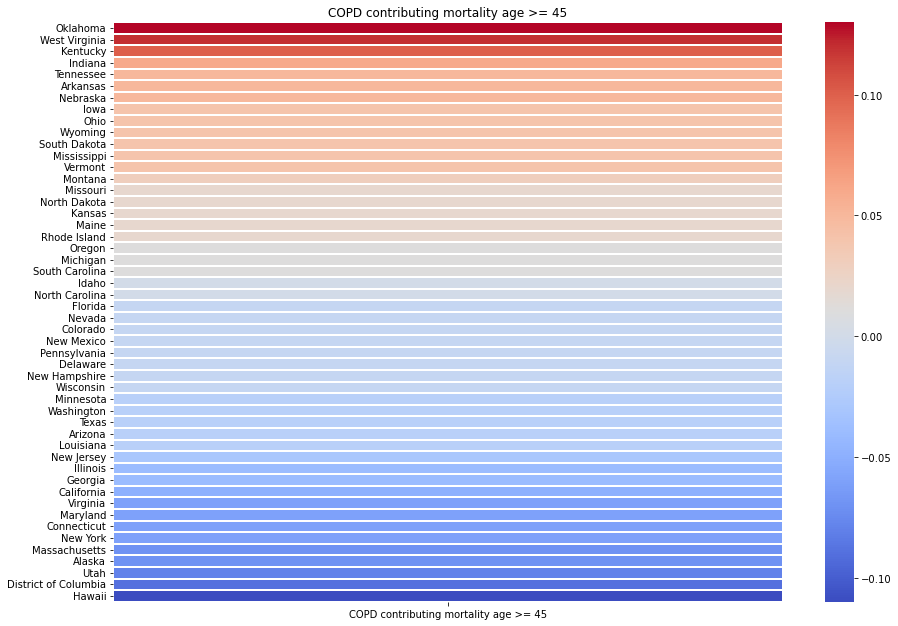

In [61]:
state_disease_heatmap('COPD contributing mortality age >= 45')

'COPD prevalence age >= 18'

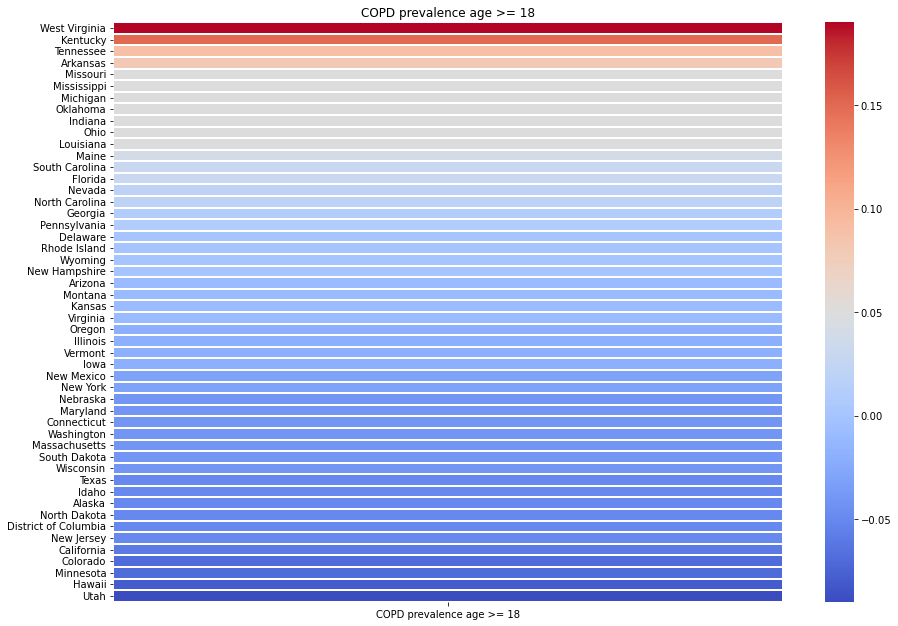

In [62]:
state_disease_heatmap('COPD prevalence age >= 18')

'smoking and COPD prevalence age >= 18'

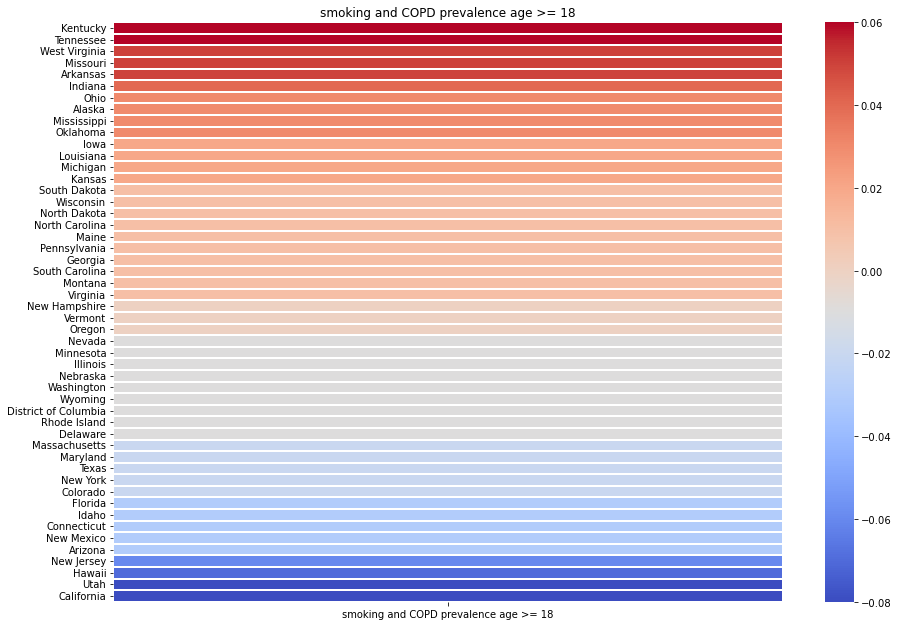

In [63]:
state_disease_heatmap('smoking and COPD prevalence age >= 18')

This provides an easy to read series of graphs to reference for disease probablities by state. To summarize, the top five states to target for CDI disease rates are:

Cancer, incidence
- West Virginia, Kentucky, Maine, Arkasas, Tennessee

Cancer, mortality
- West Virginia, Kentucky, Nevada, Maine, Arkasas

Asthma prevalence
- Maine, Rhode Island, West Virginia, Vermont, New Hampshire

CPOD prevalence
- West Virginia, Kentucky, Tennessee, Arkansas, Mississippi

COPD mortality
- Oklahoma, West Virginia, Kentucky, Indiana, Tennessee

Smoking and COPD prevalence
- Kentucky, Tennessee, West Virginia, Missouri, Arkansas

Take the top five states that are most positively correlated with a disease and plot against the AQI categories.

In [64]:
temp = corrmat.loc['Good Days':'smoking and COPD prevalence age >= 18','Alaska':'Wyoming'].stack().to_frame()
aqi = temp.loc['Good Days':'Hazardous Days',:].reset_index()
aqi.columns = ['aqi', 'state', 'value']

cdi = temp.loc['Cancer of the lung and bronchus, incidence':'smoking and COPD prevalence age >= 18'].reset_index()
cdi.columns = ['cdi', 'state', 'value']

In [65]:
# merge the cdi and aqi frames on state
merged_aqi_cdi = cdi.merge(aqi, left_on='state', right_on='state')
merged_aqi_cdi.columns = ['cdi_category', 'state', 'cdi_value', 'aqi_category', 'aqi_value']

In [66]:
# re-arrange cols to keep values next to labels
merged_aqi_cdi = merged_aqi_cdi.reindex(columns=['state', 'cdi_category', 'cdi_value', 'aqi_category', 'aqi_value'])

In [67]:
def plot_aqi_for_cdi(cdi_category=None, aqi_category=None, colors=None, markers=None):
    assert cdi_category, 'you must provide a CDI category to plot'
    assert aqi_category, 'you must provide an AQI category to plot'
    assert colors, 'you must provide a list of colors for each aqi_category'
    assert markers, 'you must provide a list of markers for each aqi_category'
    
    fig = plt.figure(figsize=(12,6))

    for i,aqi in enumerate(aqi_category):
        # filter for the cdi and aqi category that we want
        data = merged_aqi_cdi[(merged_aqi_cdi.cdi_category == cdi_category) &
                      (merged_aqi_cdi.aqi_category == aqi)] 
        # sort then truncate to top five states
        data = data.sort_values(by='cdi_value', ascending=False).iloc[:5,:]
        
        g = sns.regplot(x='cdi_value', y='aqi_value', data=data, scatter=True,
                     color=colors[i], marker=markers[i], ci=None, label=aqi)

    g.set(ylabel=f"{cdi_category}", xlabel='AQI measure')
    g.set(title=f"Top Five AQI Correlations to {cdi_category} ")
    fig.legend(loc='lower right')
    plt.show();

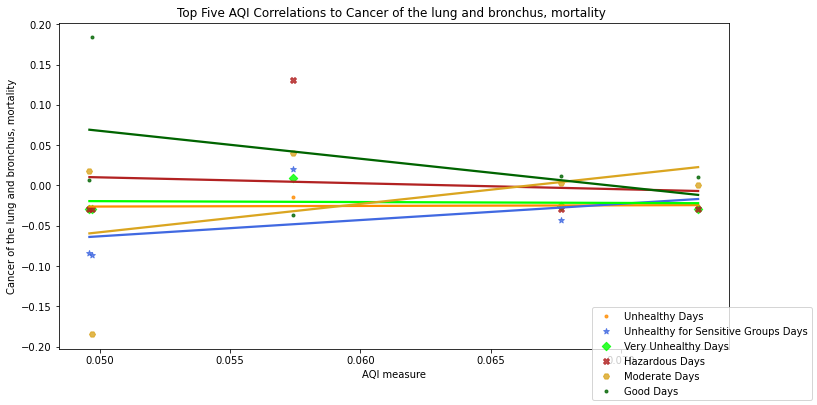

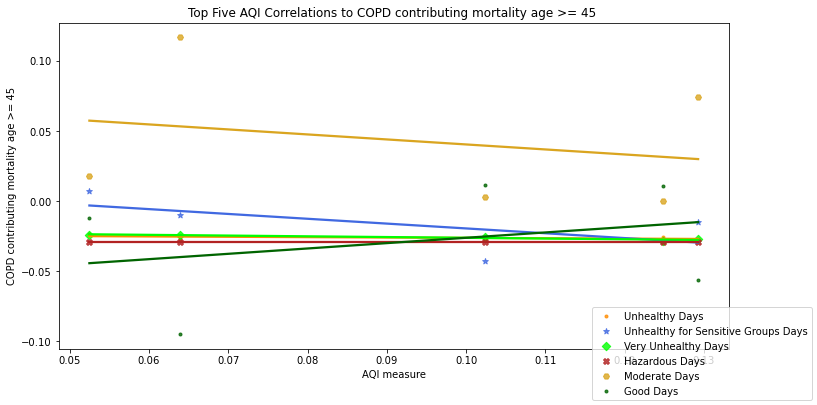

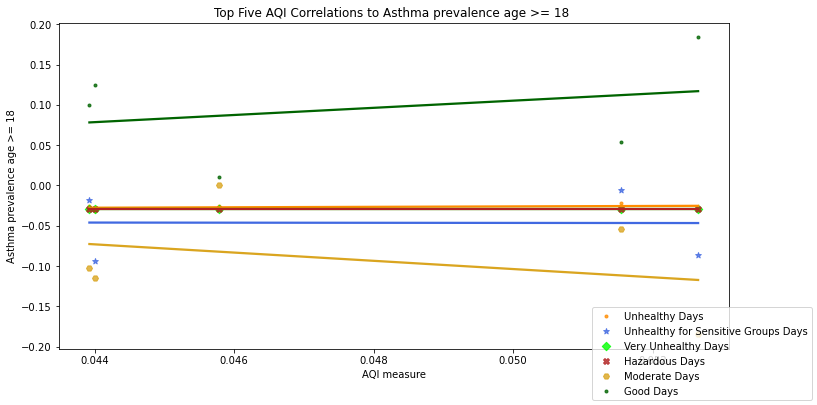

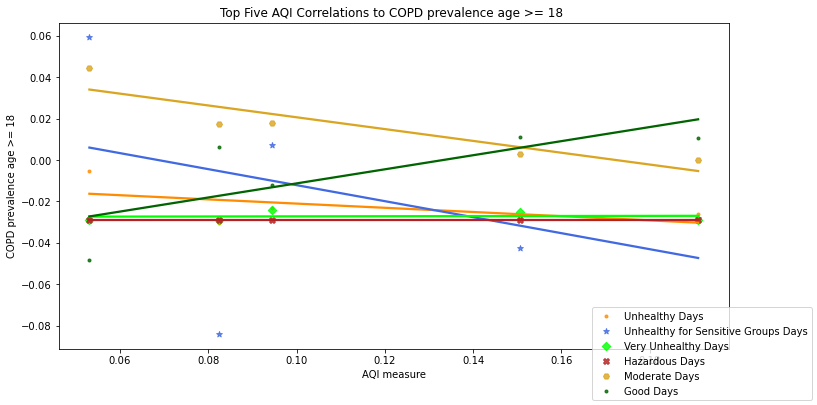

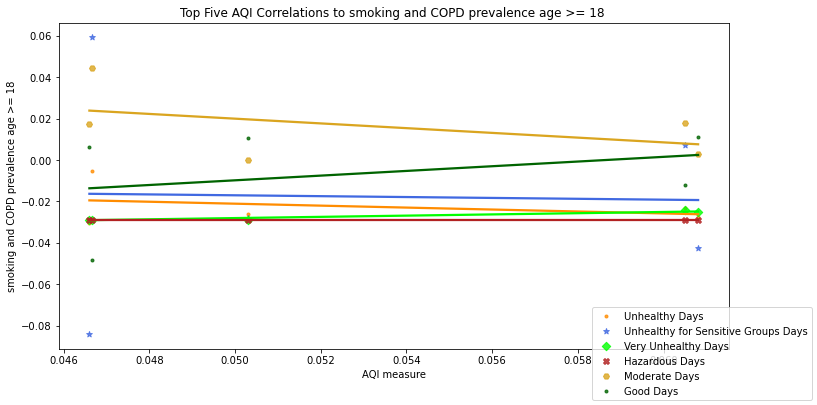

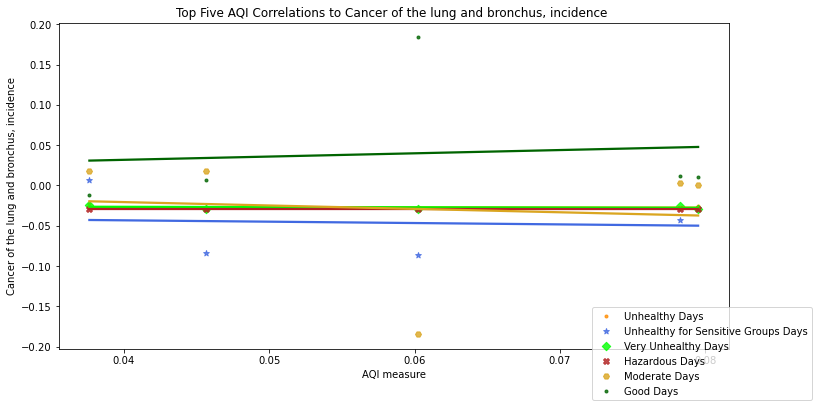

In [68]:
# convert CDI categories to set to make unique and plot
cdi_category = set(merged_aqi_cdi['cdi_category'].to_list())
# same for AQI
aqi_category = set(merged_aqi_cdi['aqi_category'].to_list())
# provide colors and markers that are same size as aqi_category
colors = ['darkorange', 'royalblue', 'lime', 'firebrick', 'goldenrod', 'darkgreen', 'gold', 'salmon', 'indigo']
markers = ['.','*','D','X','H','.','^','v','s']

for cdi in cdi_category:
    plot_aqi_for_cdi(cdi, aqi_category, colors, markers)

The only trend here that is not linked to the frequency bias of Good Days and Moderate Days (meaning that there are substantially more of these days than others) is that COPD prevalence and mortality are negatively correlated with 'Unhealthy for Sensitive Groups Days'.

Let's do the same for the AQI component measures

In [69]:
temp = corrmat.loc['Max AQI':'smoking and COPD prevalence age >= 18','Alaska':'Wyoming'].stack().to_frame()
aqi = temp.loc['Max AQI':'Days PM10',:].reset_index()
aqi.columns = ['aqi', 'state', 'value']

cdi = temp.loc['Cancer of the lung and bronchus, incidence':'smoking and COPD prevalence age >= 18'].reset_index()
cdi.columns = ['cdi', 'state', 'value']

In [70]:
# merge the cdi and aqi frames on state
merged_aqi_cdi = cdi.merge(aqi, left_on='state', right_on='state')
merged_aqi_cdi.columns = ['cdi_category', 'state', 'cdi_value', 'aqi_category', 'aqi_value']

In [71]:
# re-arrange cols to keep values next to labels
merged_aqi_cdi = merged_aqi_cdi.reindex(columns=['state', 'cdi_category', 'cdi_value', 'aqi_category', 'aqi_value'])

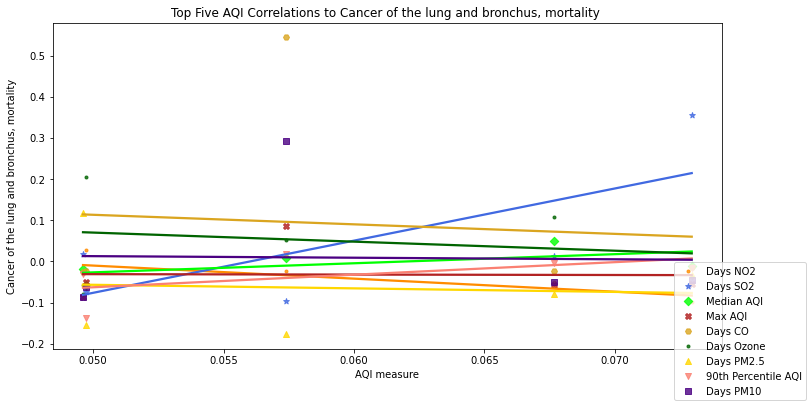

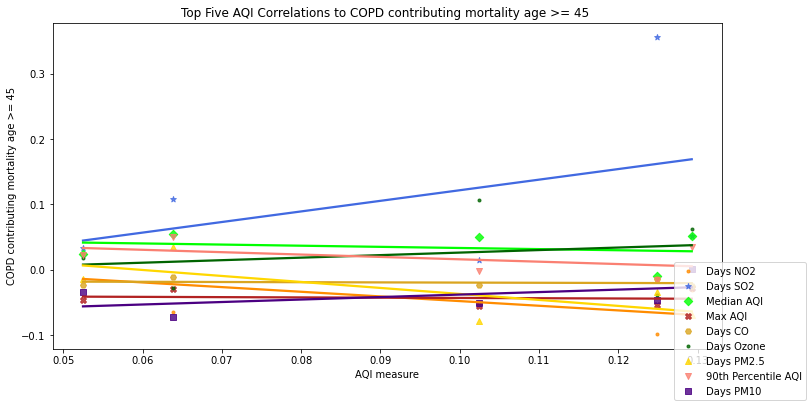

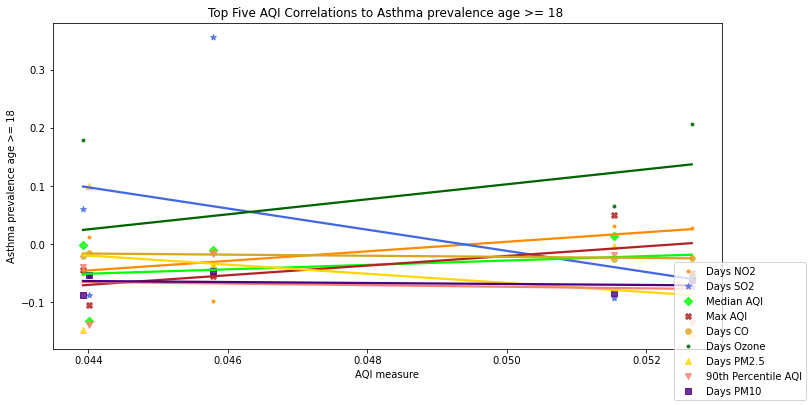

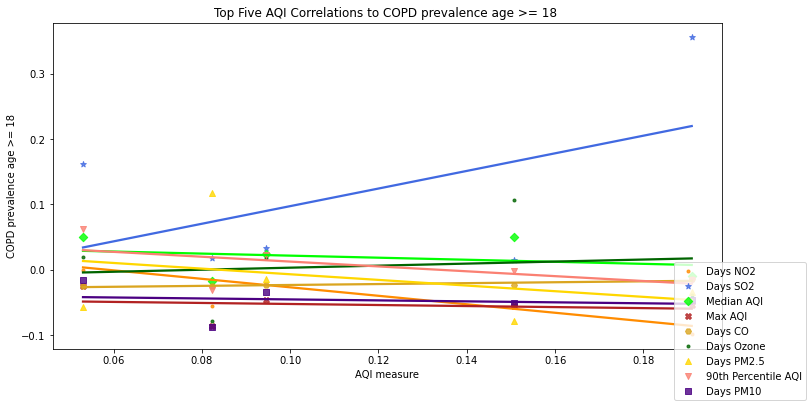

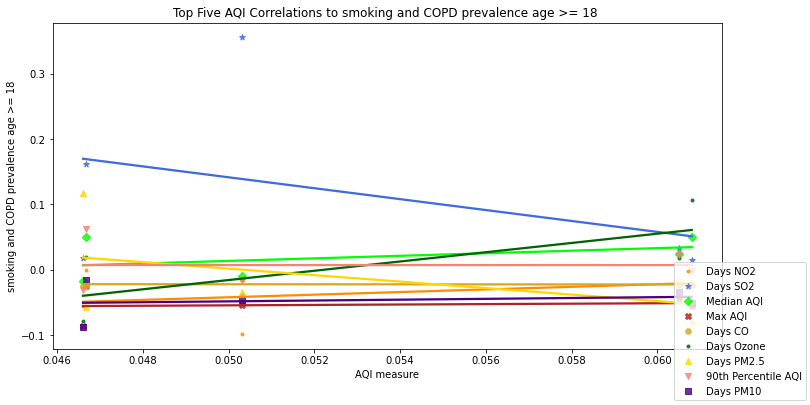

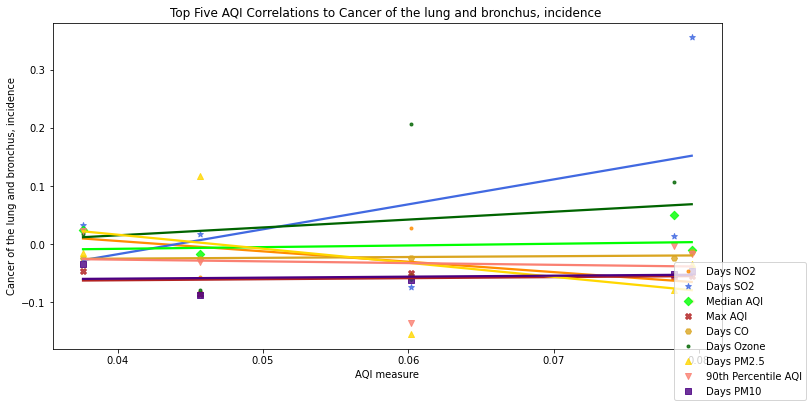

In [72]:
# convert CDI categories to set to make unique and plot
cdi_category = set(merged_aqi_cdi['cdi_category'].to_list())
# same for AQI
aqi_category = set(merged_aqi_cdi['aqi_category'].to_list())
# provide list of colors and markers for each aqi_category
colors = ['darkorange', 'royalblue', 'lime', 'firebrick', 'goldenrod', 'darkgreen', 'gold', 'salmon', 'indigo']
markers = ['.','*','D','X','H','.','^','v','s']

for cdi in cdi_category:
    plot_aqi_for_cdi(cdi, aqi_category, colors, markers)

Let's summarize the findings above:

<table style="width:100%">
   <tr>
       <th colspan="2" style="text-align:center">Positve correlations</th>
   </tr>
  <tr>
    <th style="text-align:left">AQI category</th>
    <th style="text-align:left">CDI disease</th>
  </tr>   
   <tr>
      <td style="text-align:left">Days SO2</td>
      <td style="text-align:left">COPD prevalence, cancer incidence, cancer mortality, COPD mortality</td>
   </tr>
   <tr>
      <td style="text-align:left">Days NO2</td>
      <td style="text-align:left">asthma prevalence (weak)</td>
   </tr>
   <tr>
      <td style="text-align:left">Days Ozone</td>
      <td style="text-align:left">asthma prevalence, COPD mortality (weak)</td>
   </tr>
   <tr>
      <td style="text-align:left">Max AQI</td>
      <td style="text-align:left">asthma prevalence (weak), cancer incidence</td>
   </tr>
</table>

<table style="width:100%">
   <tr>
       <th colspan="2" style="text-align:center">Negative correlations</th>
   </tr>
  <tr>
    <th style="text-align:left">AQI category</th>
    <th style="text-align:left">CDI disease</th>
  </tr>   
   <tr>
      <td style="text-align:left">Days SO2</td>
      <td style="text-align:left">Days CO, Days Ozone</td>
   </tr>
   <tr>
      <td style="text-align:left">Days Ozone</td>
      <td style="text-align:left">COPD prevalence</td>
   </tr>
</table>


<a href='#contents' style="float: right;">[back to toc]</a>
<a id='save'></a>
## 1.8 Save Data
Save the data back to the interim store, overwriting what is there.

In [73]:
# save the data to interim dir
datapath = '../data/interim/'
save_file(merged_aqi_cdi, 'merged_AQI_CDI.csv', datapath)

Writing file.  "../data/interim/merged_AQI_CDI.csv"


<a href='#contents' style="float: right;">[back to toc]</a>
<a id='summary'></a>
## 1.9 Summary

It looks like the best AQI features to predict CDI disease features to carry forth are the following:
- Days SO2
- Days NO2
- Days Ozone
- Max AQI

We've also determined the best states to target for each CDI disease category.

The next phase of this project will be the Model Selection Jupyter notebook. There, more feature engineering will be done, and Regression models will be fit in order to determine which model has the lowest error. 